In [20]:
import drms
import json, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick
from datetime import datetime as dt_obj
import urllib
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy import timeseries as ts
from datetime import datetime, timedelta
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
import drms
import sunpy.io
import sunpy.map
from sunpy.coordinates import frames
from sunpy.visualization.colormaps import color_tables as ct
from matplotlib.dates import *
import matplotlib.image as mpimg
from IPython.display import Image
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
# import the final table
path = './'
df_table = pd.read_csv(f'{path}/GSs_50nT.csv')

In [4]:
# show the names of columns
df_table.columns

Index(['Year', 'month', 'day', 'time/UT', 'Dst', 'CME_onset', 'CME_speed',
       'CME_AW', 'MPA', 'Flare_Year', 'Flare_Month', 'Flare_Day',
       'Flare_onset', 'Flare_peak', 'Flare_end', 'C-class', 'latitude',
       'longitude', 'AR number'],
      dtype='object')

In [5]:
df_table.head()

Year  month day  time/UT  Dst  CME_onset  CME_speed  CME_AW   MPA   
0  2010      2  15       24  -59  12/13:42u        509     360   44u  \
1  2010      4   6       15  -81   03/10:34        668     360   171   
2  2010      5  29       13  -80   24/14:06        427     360   280   
3  2010      8   4        2  -74   01/13:42        850     360    84   
4  2011      3  11        6  -83  07/20:00u       2125     360  313u   

   Flare_Year  Flare_Month  Flare_Day Flare_onset Flare_peak Flare_end   
0        2010            2         12       11:19      11:26     11:28  \
1        2010            4          3       09:04      09:54     10:58   
2        2010            5         24       13:05      14:46     15:50   
3        2010            8          1       07:55      08:26     09:35   
4        2011            3          7       19:43      20:12     20:58   

   C-class latitude longitude      AR number  
0    83.00       26       -11          11046  
1     0.74      -25         0          11059  
2     0.11       13        31  no/large area  
3     3.20       20       -36          11092  
4    37.00       31        53          11164

In [6]:
def create_datetime(row):
    '''
    Make a datetime column from a row in a dataframe.
    '''
    yyyy = int(row['Flare_Year'])
    mm = int(row['Flare_Month'])
    dd = int(row['Flare_Day'])
    flare_onset = row['Flare_onset']
    time = dt_obj.strptime(flare_onset, '%H:%M')
    return dt_obj(yyyy, mm, dd, time.hour, time.minute)

In [7]:
# add a datetime column for the flare onset time
df_table['datetime_flare'] = df_table.apply(create_datetime, axis=1)

In [8]:
df_table.head()

Year  month day  time/UT  Dst  CME_onset  CME_speed  CME_AW   MPA   
0  2010      2  15       24  -59  12/13:42u        509     360   44u  \
1  2010      4   6       15  -81   03/10:34        668     360   171   
2  2010      5  29       13  -80   24/14:06        427     360   280   
3  2010      8   4        2  -74   01/13:42        850     360    84   
4  2011      3  11        6  -83  07/20:00u       2125     360  313u   

   Flare_Year  Flare_Month  Flare_Day Flare_onset Flare_peak Flare_end   
0        2010            2         12       11:19      11:26     11:28  \
1        2010            4          3       09:04      09:54     10:58   
2        2010            5         24       13:05      14:46     15:50   
3        2010            8          1       07:55      08:26     09:35   
4        2011            3          7       19:43      20:12     20:58   

   C-class latitude longitude      AR number      datetime_flare  
0    83.00       26       -11          11046 2010-02-12 11:19:00  
1     0.74      -25         0          11059 2010-04-03 09:04:00  
2     0.11       13        31  no/large area 2010-05-24 13:05:00  
3     3.20       20       -36          11092 2010-08-01 07:55:00  
4    37.00       31        53          11164 2011-03-07 19:43:00

In [11]:
c = drms.Client()
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_dconS',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_dconS',
 'hmi.sharp_cea_720s_nrt']

In [13]:
# set the values here manually
select_year = '2010'
select_month = '08'
select_day = '01'

central_hour = '07'
central_minute = '55'

# +/- dt time
dt_window = 12

start_hour = '00' # central_hour - dt_window
start_minute = central_minute

end_hour = '23' # central_hour + dt_window
end_minute = central_minute

noaa_ar = '11092'  # NOAA AR No.
data_type = 'hmi.sharp_cea_720s'

# Set a series
si = c.info(data_type)

In [14]:
# To find more information about the FITS header keywords that belong to any given series, we can use the following command
si.keywords

type  recscope                    defval   
name                                                                 
cparms_sg000            string  variable             compress Rice  \
magnetogram_bzero       double  variable                         0   
magnetogram_bscale      double  variable                       0.1   
cparms_sg001            string  variable                             
bitmap_bzero            double  variable                         0   
bitmap_bscale           double  variable                         1   
cparms_sg002            string  variable             compress Rice   
Dopplergram_bzero       double  variable                         0   
Dopplergram_bscale      double  variable                       0.5   
cparms_sg003            string  variable             compress Rice   
continuum_bzero         double  variable                     97304   
continuum_bscale        double  variable                         3   
cparms_sg004            string  variable             compress Rice   
Bp_bzero                double  variable                         0   
Bp_bscale               double  variable                      0.01   
cparms_sg005            string  variable             compress Rice   
Bt_bzero                double  variable                         0   
Bt_bscale               double  variable                      0.01   
cparms_sg006            string  variable             compress Rice   
Br_bzero                double  variable                         0   
Br_bscale               double  variable                      0.01   
cparms_sg007            string  variable             compress Rice   
Bp_err_bzero            double  variable                         0   
Bp_err_bscale           double  variable                     0.001   
cparms_sg008            string  variable             compress Rice   
Bt_err_bzero            double  variable                         0   
Bt_err_bscale           double  variable                     0.001   
cparms_sg009            string  variable             compress Rice   
Br_err_bzero            double  variable                         0   
Br_err_bscale           double  variable                     0.001   
cparms_sg010            string  variable             compress Rice   
conf_disambig_bzero     double  variable                         0   
conf_disambig_bscale    double  variable                         1   
DATE                      time  variable     -4712.01.01_11:59:28Z   
DATE_S                    time  variable     -4712.01.01_11:59:28Z   
DATE_B                    time  variable     -4712.01.01_11:59:28Z   
DATE__OBS                 time  variable  -4712.01.01_11:59:28.00Z   
DATE-OBS                  time  variable  -4712.01.01_11:59:28.00Z   
T_OBS                     time  variable  -4712.01.01_11:59:28_TAI   
T_REC                     time     ts_eq  -4712.01.01_11:59:28_TAI   
T_REC_epoch               time  constant   1993.01.01_00:00:00_TAI   
T_REC_step               float  constant                     720.0   
T_REC_unit              string  constant                      secs   
CADENCE                  float  constant                     720.0   
USFLUX                   float  variable                       nan   
MEANGAM                  float  variable                       nan   
MEANGBT                  float  variable                       nan   
MEANGBZ                  float  variable                       nan   
MEANGBH                  float  variable                       nan   
MEANJZD                  float  variable                       nan   
TOTUSJZ                  float  variable                       nan   
MEANALP                  float  variable                       nan   
MEANJZH                  float  variable                       nan   
TOTUSJH                  float  variable                       nan   
ABSNJZH                  float  variable                       nan   
SAVNCPP                  float  vari

In [15]:
# To see all the segments associated with the series hmi.sharp_cea_720s:
si.segments

type       units protocol     dims   
name                                                
magnetogram     int       Gauss     fits  VARxVAR  \
bitmap         char  Enumerated     fits  VARxVAR   
Dopplergram     int         m/s     fits  VARxVAR   
continuum       int        DN/s     fits  VARxVAR   
Bp              int       Gauss     fits  VARxVAR   
Bt              int       Gauss     fits  VARxVAR   
Br              int       Gauss     fits  VARxVAR   
Bp_err          int       Gauss     fits  VARxVAR   
Bt_err          int       Gauss     fits  VARxVAR   
Br_err          int       Gauss     fits  VARxVAR   
conf_disambig  char        none     fits  VARxVAR   

                                                      note  
name                                                        
magnetogram    Line-of-sight magnetogram in CEA projection  
bitmap               Mask for the patch in CEA coordinates  
Dopplergram                  Dopplergram in CEA projection  
continuum                  Intensitygram in CEA projection  
Bp                                B_phi, positive westward  
Bt                             B_theta, positive southward  
Br                                        B_r, positive up  
Bp_err                         Standard deviation of B_phi  
Bt_err                       Standard deviation of B_theta  
Br_err                           Standard deviation of B_r  
conf_disambig          confidence of disambiguation result

In [16]:
# To convert the keyword `T_REC` into a datetime object, we can use the function below
def parse_tai_string(tstr, datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime:
        return dt_obj(year, month, day, hour, minute)
    else:
        return year, month, day, hour, minute

In [100]:
keys = c.query(f'hmi.sharp_cea_720s[][{select_year}.{select_month}.{select_day}_{start_hour}:{start_minute} - {select_year}.{select_month}.{select_day}_{end_hour}:{end_minute}][? NOAA_ARS ~ "{noaa_ar}" ?]',
                      key='T_REC, HARPNUM, NOAA_ARS, USFLUX, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ, MEANALP, MEANJZH, TOTUSJH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, R_VALUE')
keys

T_REC  HARPNUM NOAA_ARS        USFLUX  MEANGAM   
0    2010.08.01_01:00:00_TAI      104    11092  1.762119e+22   46.790  \
1    2010.08.01_01:12:00_TAI      104    11092  1.767450e+22   46.737   
2    2010.08.01_01:24:00_TAI      104    11092  1.747987e+22   46.764   
3    2010.08.01_01:36:00_TAI      104    11092  1.740331e+22   46.936   
4    2010.08.01_01:48:00_TAI      104    11092  1.730422e+22   46.798   
5    2010.08.01_02:00:00_TAI      104    11092  1.740603e+22   47.095   
6    2010.08.01_02:12:00_TAI      104    11092  1.735771e+22   47.289   
7    2010.08.01_02:24:00_TAI      104    11092  1.720396e+22   47.089   
8    2010.08.01_02:36:00_TAI      104    11092  1.723912e+22   47.102   
9    2010.08.01_02:48:00_TAI      104    11092  1.720726e+22   47.052   
10   2010.08.01_03:00:00_TAI      104    11092  1.713789e+22   47.166   
11   2010.08.01_03:12:00_TAI      104    11092  1.702669e+22   47.904   
12   2010.08.01_03:24:00_TAI      104    11092  1.698775e+22   47.738   
13   2010.08.01_03:36:00_TAI      104    11092  1.701722e+22   47.650   
14   2010.08.01_03:48:00_TAI      104    11092  1.693314e+22   47.890   
15   2010.08.01_04:00:00_TAI      104    11092  1.697574e+22   47.904   
16   2010.08.01_04:12:00_TAI      104    11092  1.681704e+22   48.112   
17   2010.08.01_04:24:00_TAI      104    11092  1.672016e+22   48.213   
18   2010.08.01_04:36:00_TAI      104    11092  1.649707e+22   48.224   
19   2010.08.01_04:48:00_TAI      104    11092  1.636455e+22   48.283   
20   2010.08.01_05:00:00_TAI      104    11092  1.609318e+22   48.239   
21   2010.08.01_05:12:00_TAI      104    11092  1.601404e+22   48.187   
22   2010.08.01_05:24:00_TAI      104    11092  1.588498e+22   48.315   
23   2010.08.01_05:36:00_TAI      104    11092  1.564030e+22   47.989   
24   2010.08.01_05:48:00_TAI      104    11092  1.544710e+22   47.776   
25   2010.08.01_06:00:00_TAI      104    11092  1.530720e+22   47.676   
26   2010.08.01_06:12:00_TAI      104    11092  1.519807e+22   48.125   
27   2010.08.01_06:24:00_TAI      104    11092  1.514283e+22   47.994   
28   2010.08.01_06:36:00_TAI      104    11092  1.508463e+22   48.251   
29   2010.08.01_06:48:00_TAI      104    11092  1.506738e+22   48.495   
30   2010.08.01_07:00:00_TAI      104    11092  1.514772e+22   48.402   
31   2010.08.01_07:12:00_TAI      104    11092  1.519611e+22   48.199   
32   2010.08.01_07:24:00_TAI      104    11092  1.521264e+22   48.091   
33   2010.08.01_07:36:00_TAI      104    11092  1.521362e+22   48.186   
34   2010.08.01_07:48:00_TAI      104    11092  1.527288e+22   48.412   
35   2010.08.01_08:00:00_TAI      104    11092  1.526899e+22   48.548   
36   2010.08.01_08:12:00_TAI      104    11092  1.528135e+22   48.701   
37   2010.08.01_08:24:00_TAI      104    11092  1.534890e+22   48.922   
38   2010.08.01_08:36:00_TAI      104    11092  1.541161e+22   48.977   
39   2010.08.01_08:48:00_TAI      104    11092  1.540943e+22   48.987   
40   2010.08.01_09:00:00_TAI      104    11092  1.542806e+22   48.915   
41   2010.08.01_09:12:00_TAI      104    11092  1.539152e+22   48.857   
42   2010.08.01_09:24:00_TAI      104    11092  1.533809e+22   48.912   
43   2010.08.01_09:36:00_TAI      104    11092  1.535605e+22   48.719   
44   2010.08.01_09:48:00_TAI      104    11092  1.542260e+22   48.964   
45   2010.08.01_10:00:00_TAI      104    11092  1.535077e+22   49.170   
46   2010.08.01_10:12:00_TAI      104    11092  1.530933e+22   49.309   
47   2010.08.01_10:24:00_TAI      104    11092  1.535588e+22   49.408   
48   2010.08.01_10:36:00_TAI      104    11092  1.521010e+22   49.619   
49   2010.08.01_10:48:00_TAI      104    11092  1.505816e+22   49.907   
50   2010.08.01_11:00:00_TAI      104    11092  1.488238e+22   50.224   
51   2010.08.01_11:12:00_TAI      104    11092  1.471403e+22   50.097   
52   2010.08.01_11:24:00_TAI      104    11092  1.466205e+22   50.072   
53   2010.08.01_11:36:00_TAI      104    11092  1.462889e+22   50.133   
54   201

In [101]:
t_rec = np.array([parse_tai_string(keys.T_REC[i], datetime=True) for i in range(keys.T_REC.size)])

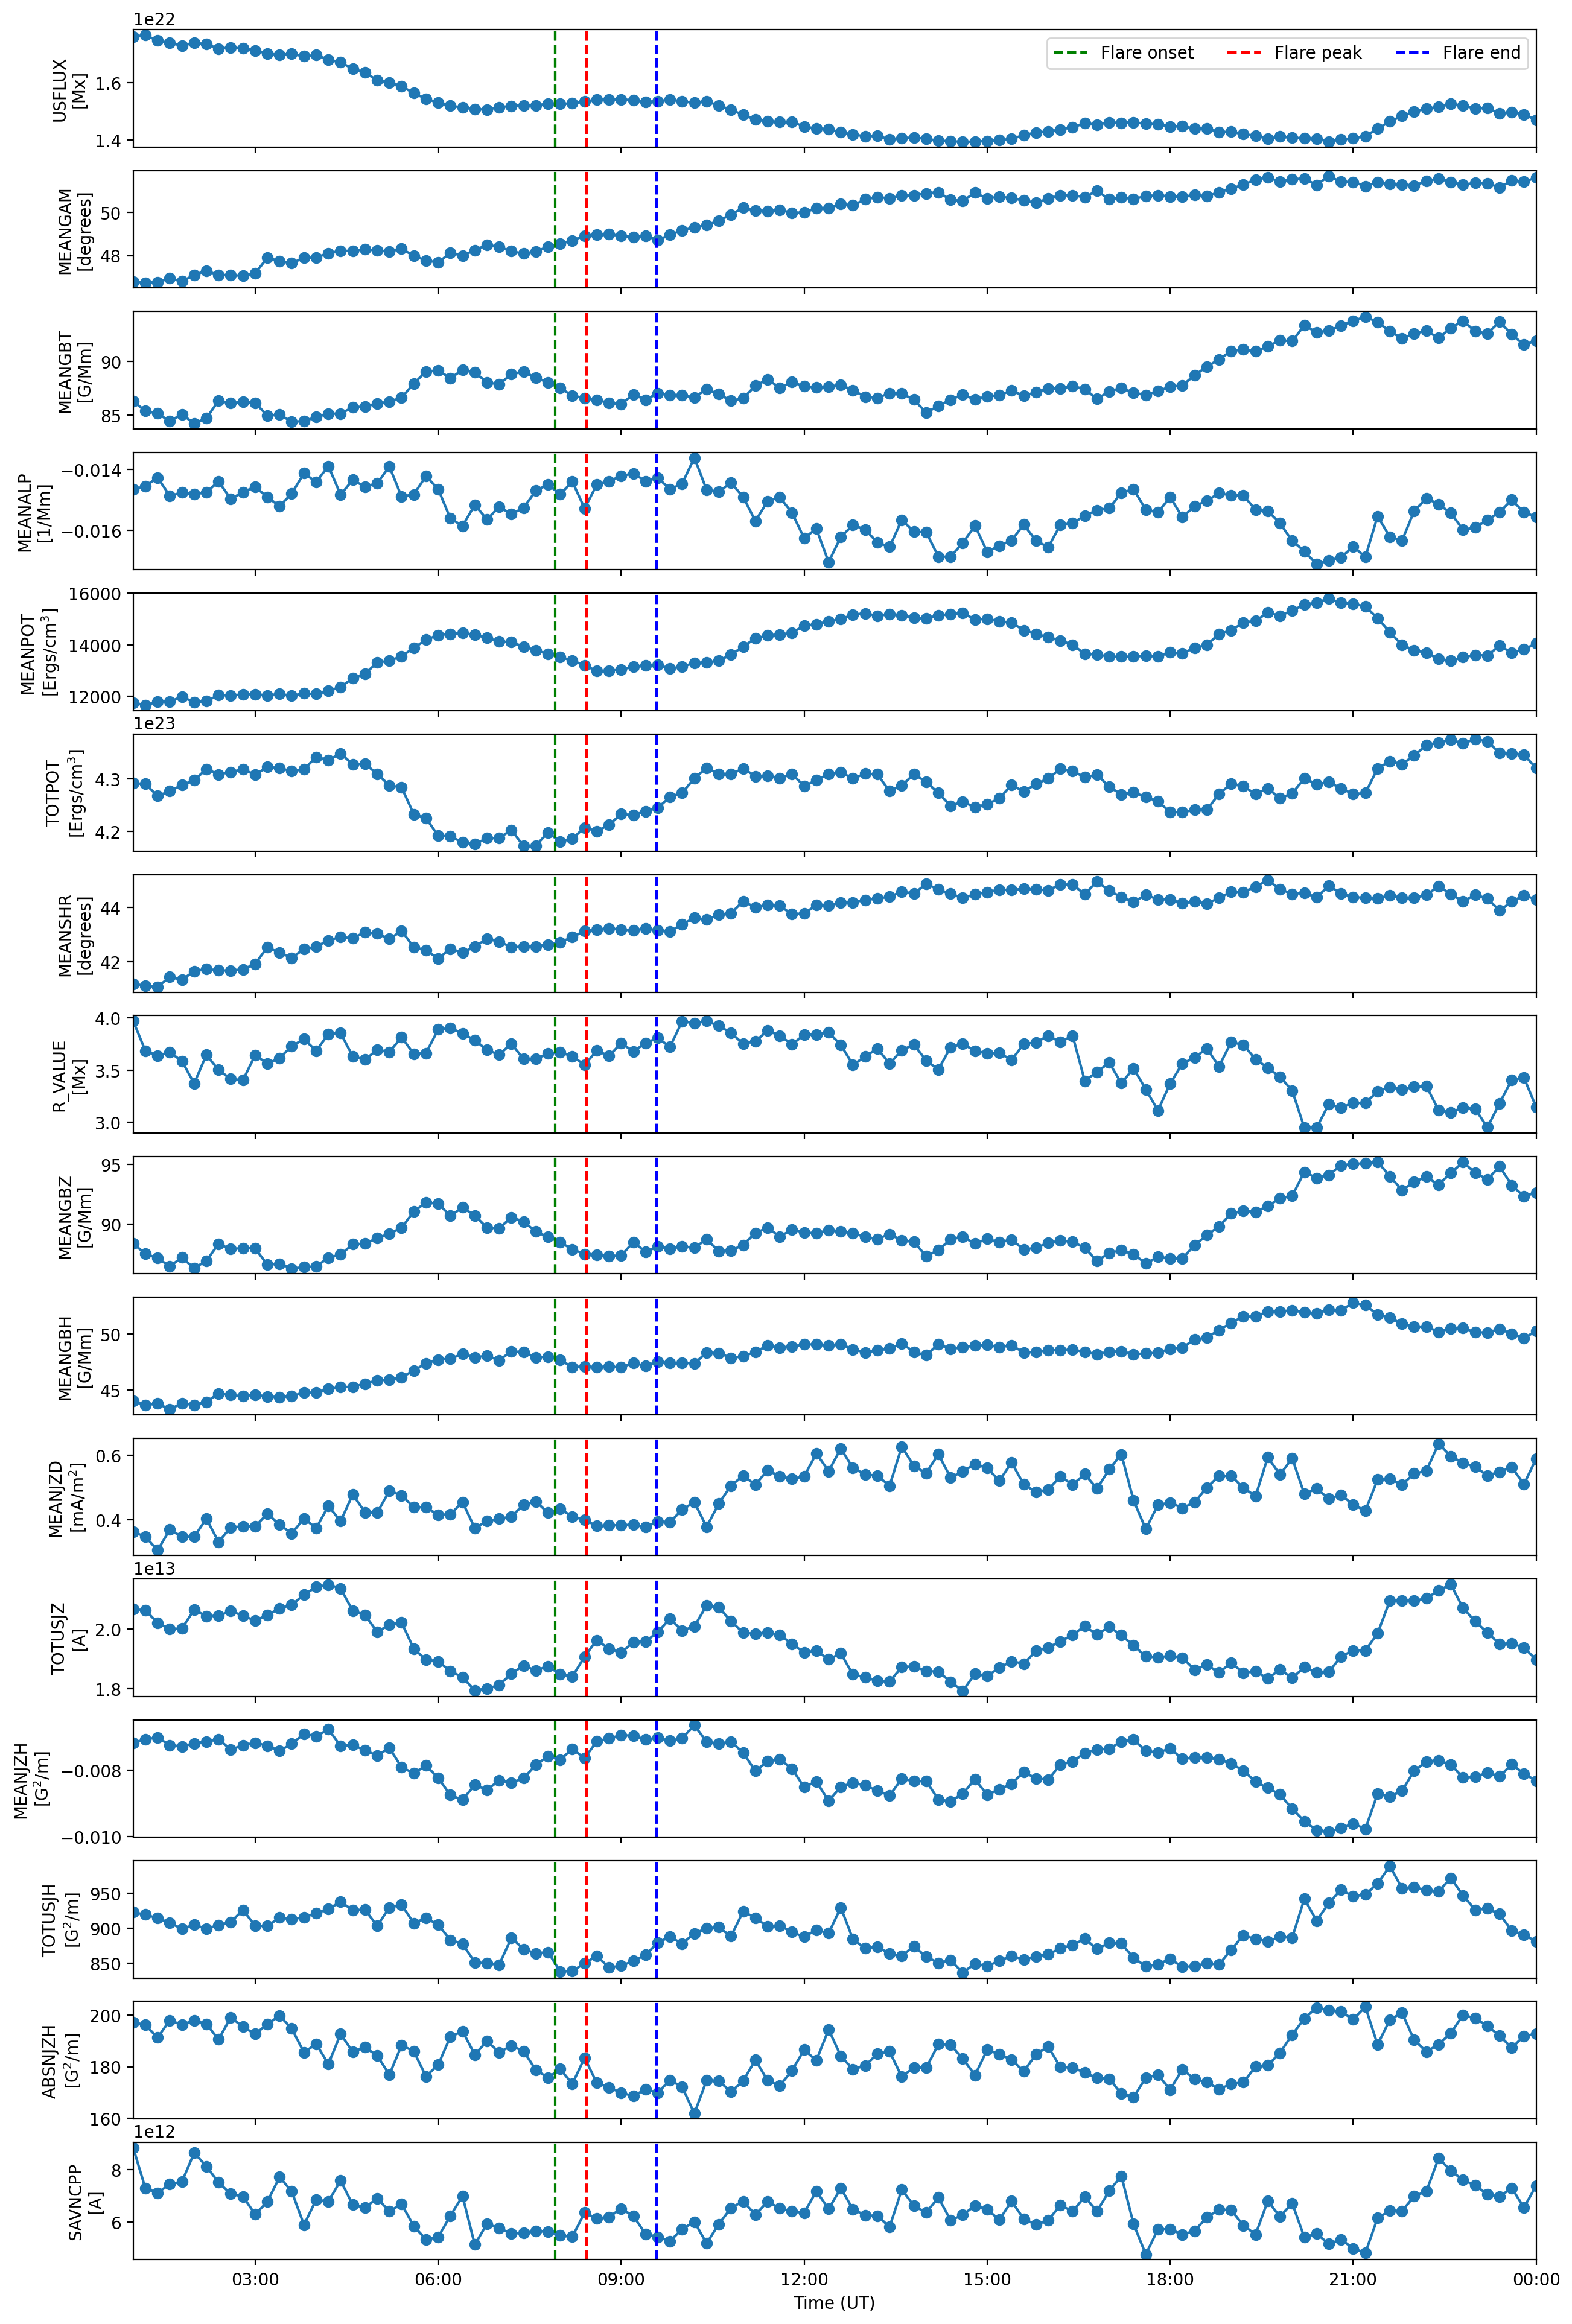

In [103]:
flare_onset_time = '07:55'
flare_peak_time = '08:26'
flare_end_time = '09:35'

flare_onset_moment = pd.to_datetime(f'{select_year}-{select_month}-{select_day} {flare_onset_time}')
flare_peak_moment = pd.to_datetime(f'{select_year}-{select_month}-{select_day} {flare_peak_time}')
flare_end_moment = pd.to_datetime(f'{select_year}-{select_month}-{select_day} {flare_end_time}')

# template
fig = plt.figure(figsize=[15,24])
# fig.suptitle('2010-08-01', y=0.91)

ax = fig.add_subplot(16,1,1)
# Plotting the vertical dashed line
ax.axvline(x=flare_onset_moment, color='g', linestyle='--', label='Flare onset')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--', label='Flare peak')
ax.axvline(x=flare_end_moment, color='b', linestyle='--', label='Flare end')
ax.legend(loc='best', ncol=3)
ax.plot(t_rec, keys['USFLUX'], 'o-')  # Total unsigned flux Total unsigned flux (Mx)
ax.set_ylabel('USFLUX\n[Mx]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,2)
ax.plot(t_rec, keys['MEANGAM'], 'o-') # Mean inclination angle MEANGAM
ax.set_ylabel('MEANGAM\n[degrees]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,3)
ax.plot(t_rec, keys['MEANGBT'], 'o-')  # Mean value of the total field gradient tot. grad. (Gauss/Mm)
ax.set_ylabel('MEANGBT\n[G/Mm]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,4)
ax.plot(t_rec, keys['MEANALP'], 'o-') # Mean twist parameter, alpha MEANALP
ax.set_ylabel('MEANALP\n[1/Mm]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,5)
ax.plot(t_rec, keys['MEANPOT'], 'o-')
ax.set_ylabel('MEANPOT\n[Ergs/cm$^3$]')  # Mean photospheric excess magnetic energy density MEANPOT
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,6)
ax.plot(t_rec, keys['TOTPOT'], 'o-') # Total photospheric magnetic energy density U_B,ph,tot (Ergs/cm^2)
ax.set_ylabel('TOTPOT\n[Ergs/cm$^3$]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,7)
ax.plot(t_rec, keys['MEANSHR'], 'o-') # Mean shear angle B_total shear angle (deg)
ax.set_ylabel('MEANSHR\n[degrees]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,8)
ax.plot(t_rec, keys['R_VALUE'], 'o-')
ax.set_ylabel('R_VALUE\n[Mx]') # Unsigned Flux R (Schrijver, 2007) R_VALUE
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,9)
# Plotting the vertical dashed line
ax.axvline(x=flare_onset_moment, color='g', linestyle='--', label='Flare onset')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--', label='Flare peak')
ax.axvline(x=flare_end_moment, color='b', linestyle='--', label='Flare end')
ax.plot(t_rec, keys['MEANGBZ'], 'o-') # Mean value of the vertical field gradient ver. grad.
ax.set_ylabel('MEANGBZ\n[G/Mm]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,10)
ax.plot(t_rec, keys['MEANGBH'], 'o-') # Mean value of the horizontal field gradient hor. grad.
ax.set_ylabel('MEANGBH\n[G/Mm]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,11)
ax.plot(t_rec, keys['MEANJZD'], 'o-')  #  Mean vertical current density J_ver (mA/m^2)
ax.set_ylabel('MEANJZD\n[mA/m$^2$]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,12)
ax.plot(t_rec, keys['TOTUSJZ'], 'o-') #  Amperes Total unsigned vertical current I_ver (A)
ax.set_ylabel('TOTUSJZ\n[A]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,13)
ax.plot(t_rec, keys['MEANJZH'], 'o-')
ax.set_ylabel('MEANJZH\n[G$^2$/m]') # Mean current helicity I helicity (G^2/m)
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,14)
ax.plot(t_rec, keys['TOTUSJH'], 'o-') # Total unsigned current helicity J_tot (A)
ax.set_ylabel('TOTUSJH\n[G$^2$/m]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,15)
ax.plot(t_rec, keys['ABSNJZH'], 'o-') # Absolute value of the net current helicity J_net (mA/m^2)
ax.set_ylabel('ABSNJZH\n[G$^2$/m]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xticklabels([])
ax.set_xlim(left=t_rec[0], right=t_rec[-1])

ax = fig.add_subplot(16,1,16)
ax.plot(t_rec, keys['SAVNCPP'], 'o-') # Sum of the Absolute Value of the Net Currents ... I_net (A)
ax.set_ylabel('SAVNCPP\n[A]')
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvline(x=flare_onset_moment, color='g', linestyle='--')
ax.axvline(x=flare_peak_moment, color='r', linestyle='--')
ax.axvline(x=flare_end_moment, color='b', linestyle='--')
ax.set_xlim(left=t_rec[0], right=t_rec[-1])
ax.set_xlabel('Time (UT)')

plt.show()

In [104]:
fig.savefig('./20100801.pdf', format='pdf', facecolor='white', bbox_inches='tight')

Check the correlation between parameters

In [74]:
# import the final table

filename = 'corr_matrix_0'
# filename = 'corr_matrix_all'
# filename = 'corr_matrix_dec'
# filename = 'corr_matrix_rise'
# filename = 'corr_matrix_cer'

# Load the data
df = pd.read_excel(f'{path}/{filename}.xlsx')
df.head()

Dst  CME_speed  CME_AW Flare_onset  flare_rise Flare_peak   
0  -74.0        850   360.0       07:55        31.0      08:26  \
1  -83.0       2125   360.0       19:43        29.0      20:12   
2 -115.0       1315   360.0       03:41        16.0      03:57   
3  -75.0        575   360.0       22:12         8.0      22:20   
4 -118.0       1915   360.0       12:33        47.0      13:20   

   flare_duration Flare_end  SF_class      USFLUX-0  ...     TOTUSJZ-0   
0           100.0     09:35       3.2  1.527288e+22  ...  1.875297e+13  \
1            75.0     20:58      37.0  6.574974e+22  ...  6.885035e+13   
2            23.0     04:04      93.0  2.409512e+22  ...  4.873651e+13   
3            12.0  22:24:00     210.0  1.596296e+22  ...  2.872951e+13   
4            97.0  14:10:00      71.0  5.525371e+22  ...  8.040034e+13   

   MEANALP-0  MEANJZH-0  TOTUSJH-0  ABSNJZH-0     SAVNCPP-0  MEANPOT-0   
0  -0.014494  -0.007585    866.199    175.719  5.637476e+12  13645.760  \
1   0.010848   0.005078   4026.154    455.828  2.469219e+13   8322.466   
2   0.053081   0.021481   2715.868    807.144  3.228063e+13   8703.333   
3   0.027567   0.010522   1524.746    274.172  1.587675e+13   9326.669   
4  -0.010147  -0.005922   5094.491    445.245  1.168301e+13  18387.650   

       TOTPOT-0  MEANSHR-0  R_VALUE-0  
0  1.364576e+04     42.629      3.659  
1  9.921369e+23     32.357      4.816  
2  4.342959e+23     39.166      4.704  
3  3.227357e+23     40.313      4.292  
4  1.836038e+24     44.522      4.811  

[5 rows x 25 columns]

In [75]:
df.columns

Index(['Dst', 'CME_speed', 'CME_AW', 'Flare_onset', 'flare_rise', 'Flare_peak',
       'flare_duration', 'Flare_end', 'SF_class', 'USFLUX-0', 'MEANGAM-0',
       'MEANGBT-0', 'MEANGBZ-0', 'MEANGBH-0', 'MEANJZD-0', 'TOTUSJZ-0',
       'MEANALP-0', 'MEANJZH-0', 'TOTUSJH-0', 'ABSNJZH-0', 'SAVNCPP-0',
       'MEANPOT-0', 'TOTPOT-0', 'MEANSHR-0', 'R_VALUE-0'],
      dtype='object')

In [76]:
# Drop unnecessary columns
df.drop(['Flare_onset','Flare_peak','Flare_end'], axis=1, inplace=True)

In [77]:
len(df), df.columns

(66,
 Index(['Dst', 'CME_speed', 'CME_AW', 'flare_rise', 'flare_duration',
        'SF_class', 'USFLUX-0', 'MEANGAM-0', 'MEANGBT-0', 'MEANGBZ-0',
        'MEANGBH-0', 'MEANJZD-0', 'TOTUSJZ-0', 'MEANALP-0', 'MEANJZH-0',
        'TOTUSJH-0', 'ABSNJZH-0', 'SAVNCPP-0', 'MEANPOT-0', 'TOTPOT-0',
        'MEANSHR-0', 'R_VALUE-0'],
       dtype='object'))

In [88]:
param_type = '0'

chosen_parameters = ['Dst', 'CME_speed', 'CME_AW', 'flare_rise', 'flare_duration',
        'SF_class', f'USFLUX-{param_type}', f'MEANGAM-{param_type}', f'MEANGBT-{param_type}',
        f'MEANGBZ-{param_type}', f'MEANGBH-{param_type}', f'MEANJZD-{param_type}', f'TOTUSJZ-{param_type}',
        f'MEANALP-{param_type}', f'MEANJZH-{param_type}', f'TOTUSJH-{param_type}', f'ABSNJZH-{param_type}',
        f'SAVNCPP-{param_type}', f'MEANPOT-{param_type}', f'TOTPOT-{param_type}', f'MEANSHR-{param_type}',
        f'R_VALUE-{param_type}']

df = df[chosen_parameters]
df.head()

Dst  CME_speed  CME_AW  flare_rise  flare_duration  SF_class   
0  -74.0        850   360.0        31.0           100.0       3.2  \
1  -83.0       2125   360.0        29.0            75.0      37.0   
2 -115.0       1315   360.0        16.0            23.0      93.0   
3  -75.0        575   360.0         8.0            12.0     210.0   
4 -118.0       1915   360.0        47.0            97.0      71.0   

       USFLUX-0  MEANGAM-0  MEANGBT-0  MEANGBZ-0  ...     TOTUSJZ-0   
0  1.527288e+22     48.412     88.037     88.951  ...  1.875297e+13  \
1  6.574974e+22     38.318     79.710     87.502  ...  6.885035e+13   
2  2.409512e+22     46.121    115.129    123.078  ...  4.873651e+13   
3  1.596296e+22     50.339    111.538    114.445  ...  2.872951e+13   
4  5.525371e+22     50.177     77.588     93.321  ...  8.040034e+13   

   MEANALP-0  MEANJZH-0  TOTUSJH-0  ABSNJZH-0     SAVNCPP-0  MEANPOT-0   
0  -0.014494  -0.007585    866.199    175.719  5.637476e+12  13645.760  \
1   0.010848   0.005078   4026.154    455.828  2.469219e+13   8322.466   
2   0.053081   0.021481   2715.868    807.144  3.228063e+13   8703.333   
3   0.027567   0.010522   1524.746    274.172  1.587675e+13   9326.669   
4  -0.010147  -0.005922   5094.491    445.245  1.168301e+13  18387.650   

       TOTPOT-0  MEANSHR-0  R_VALUE-0  
0  1.364576e+04     42.629      3.659  
1  9.921369e+23     32.357      4.816  
2  4.342959e+23     39.166      4.704  
3  3.227357e+23     40.313      4.292  
4  1.836038e+24     44.522      4.811  

[5 rows x 22 columns]

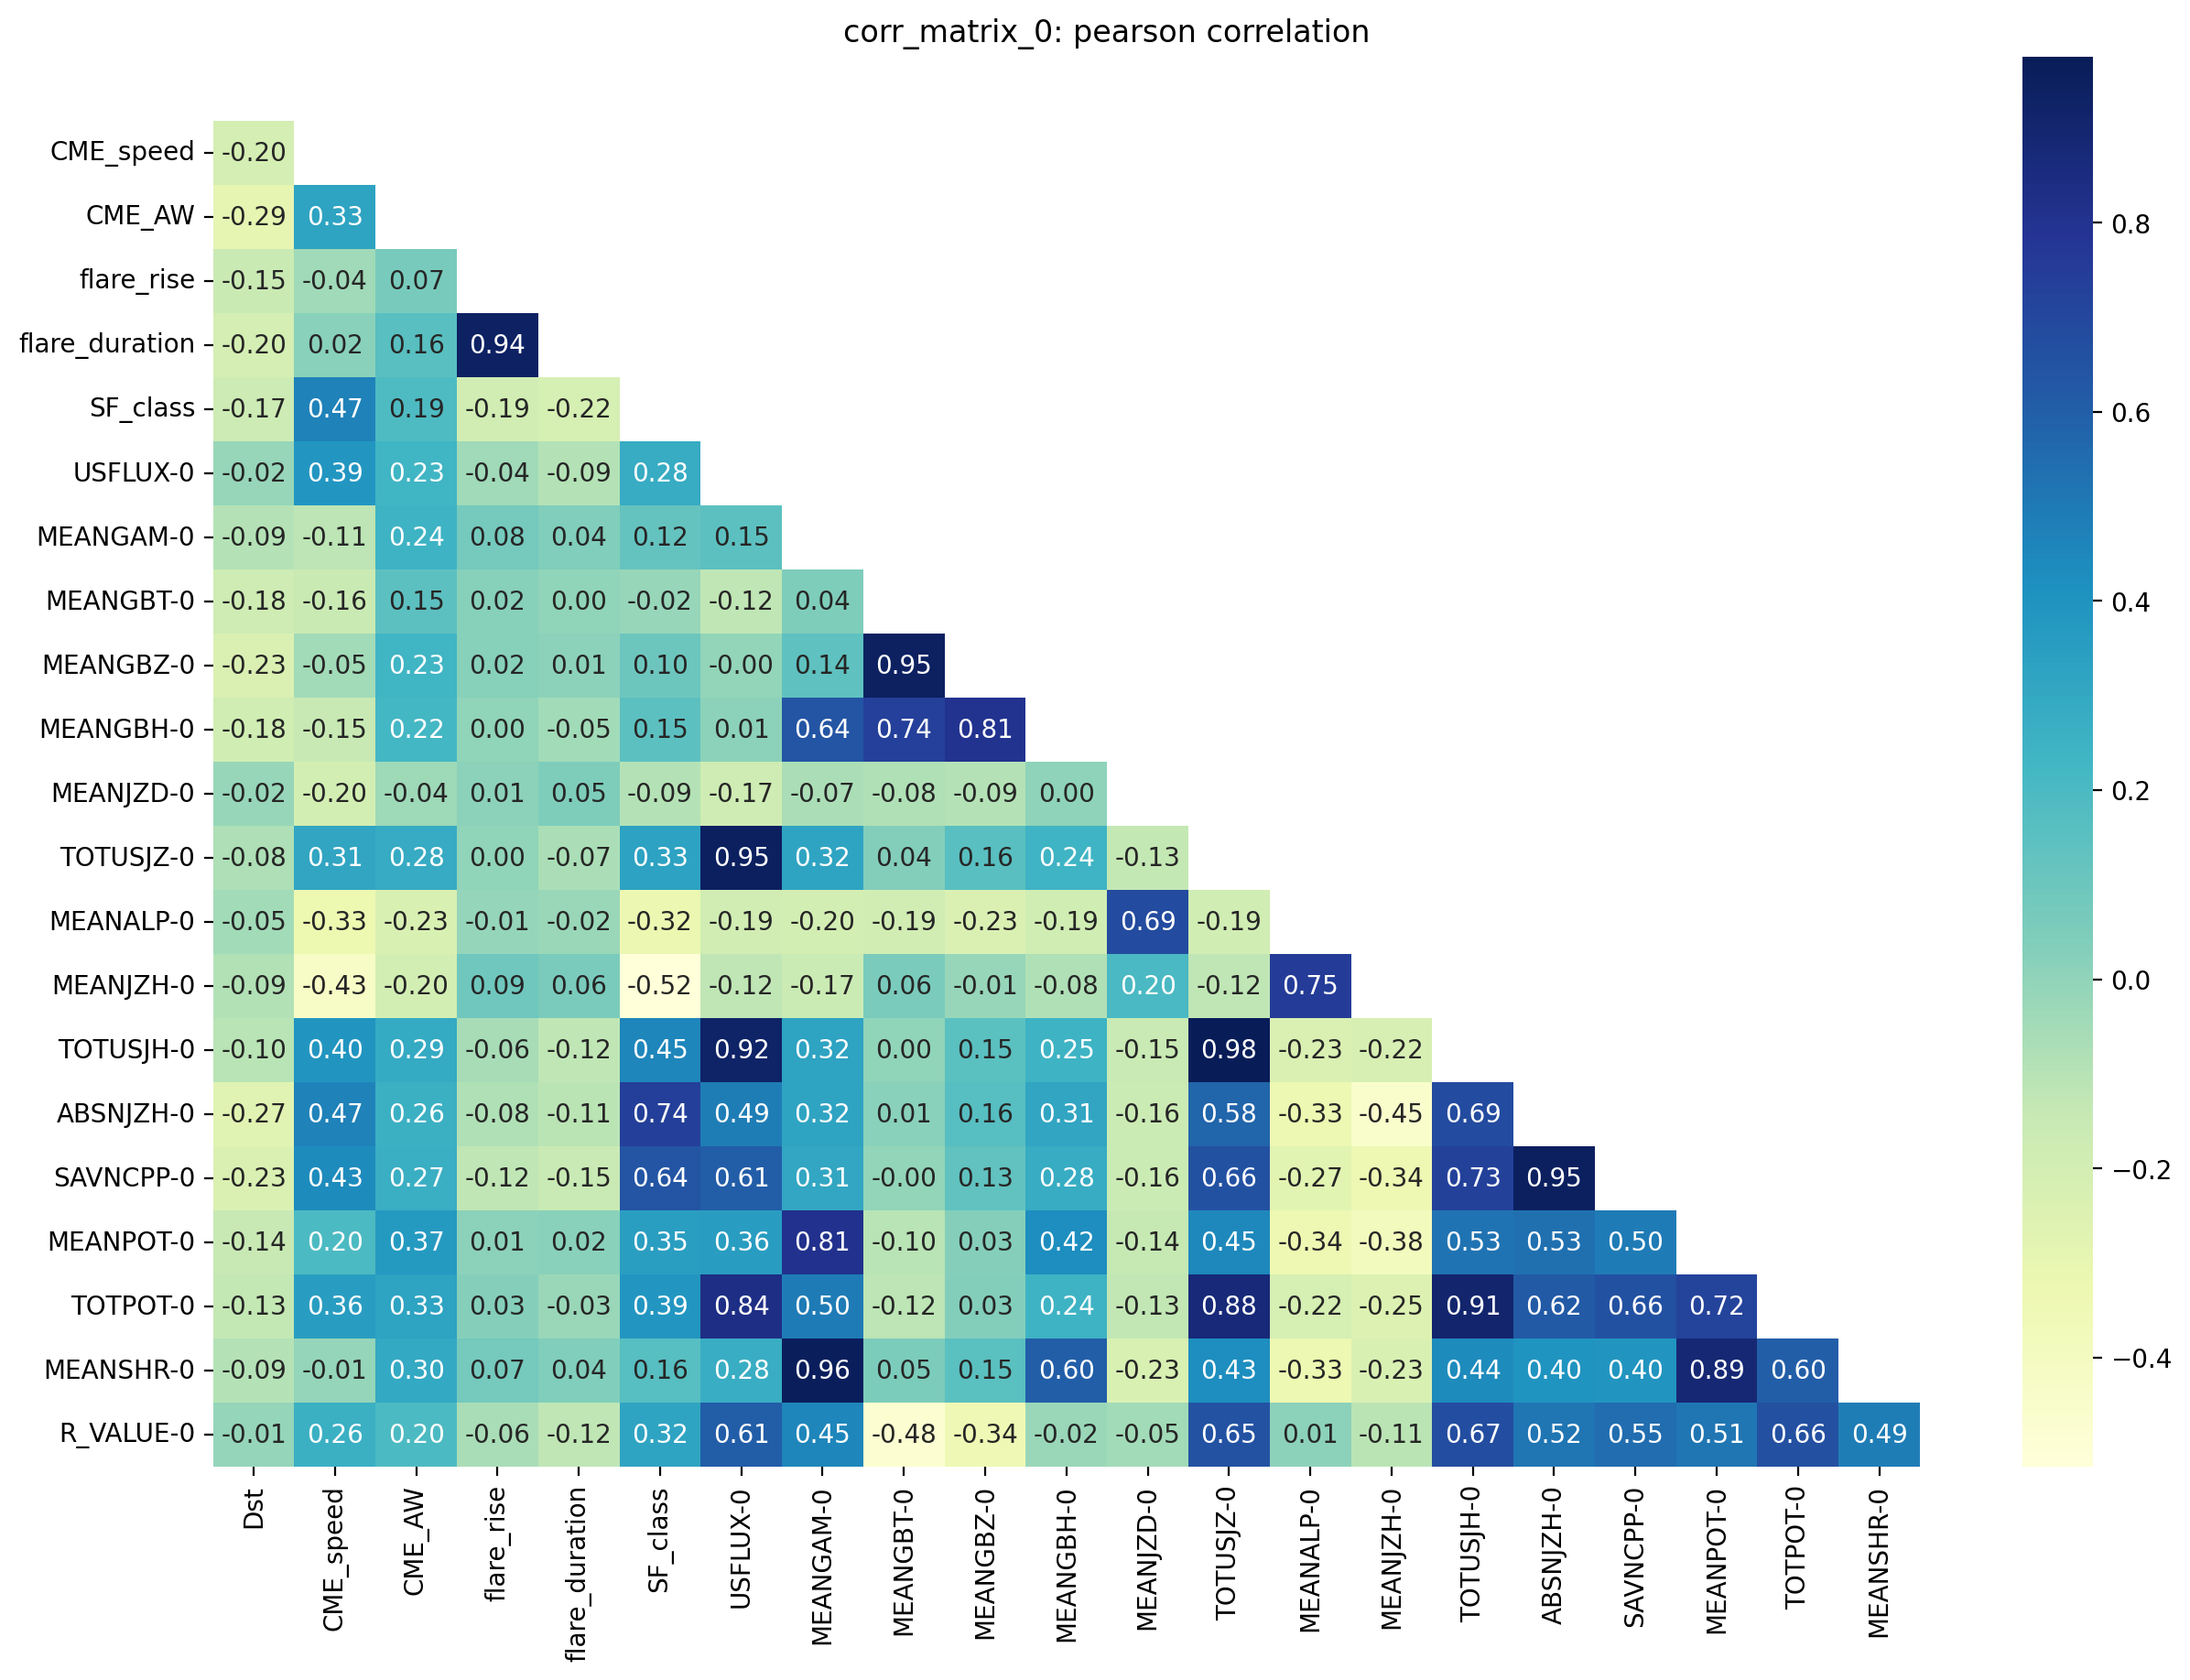

In [89]:
corr_method = 'pearson'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Create a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

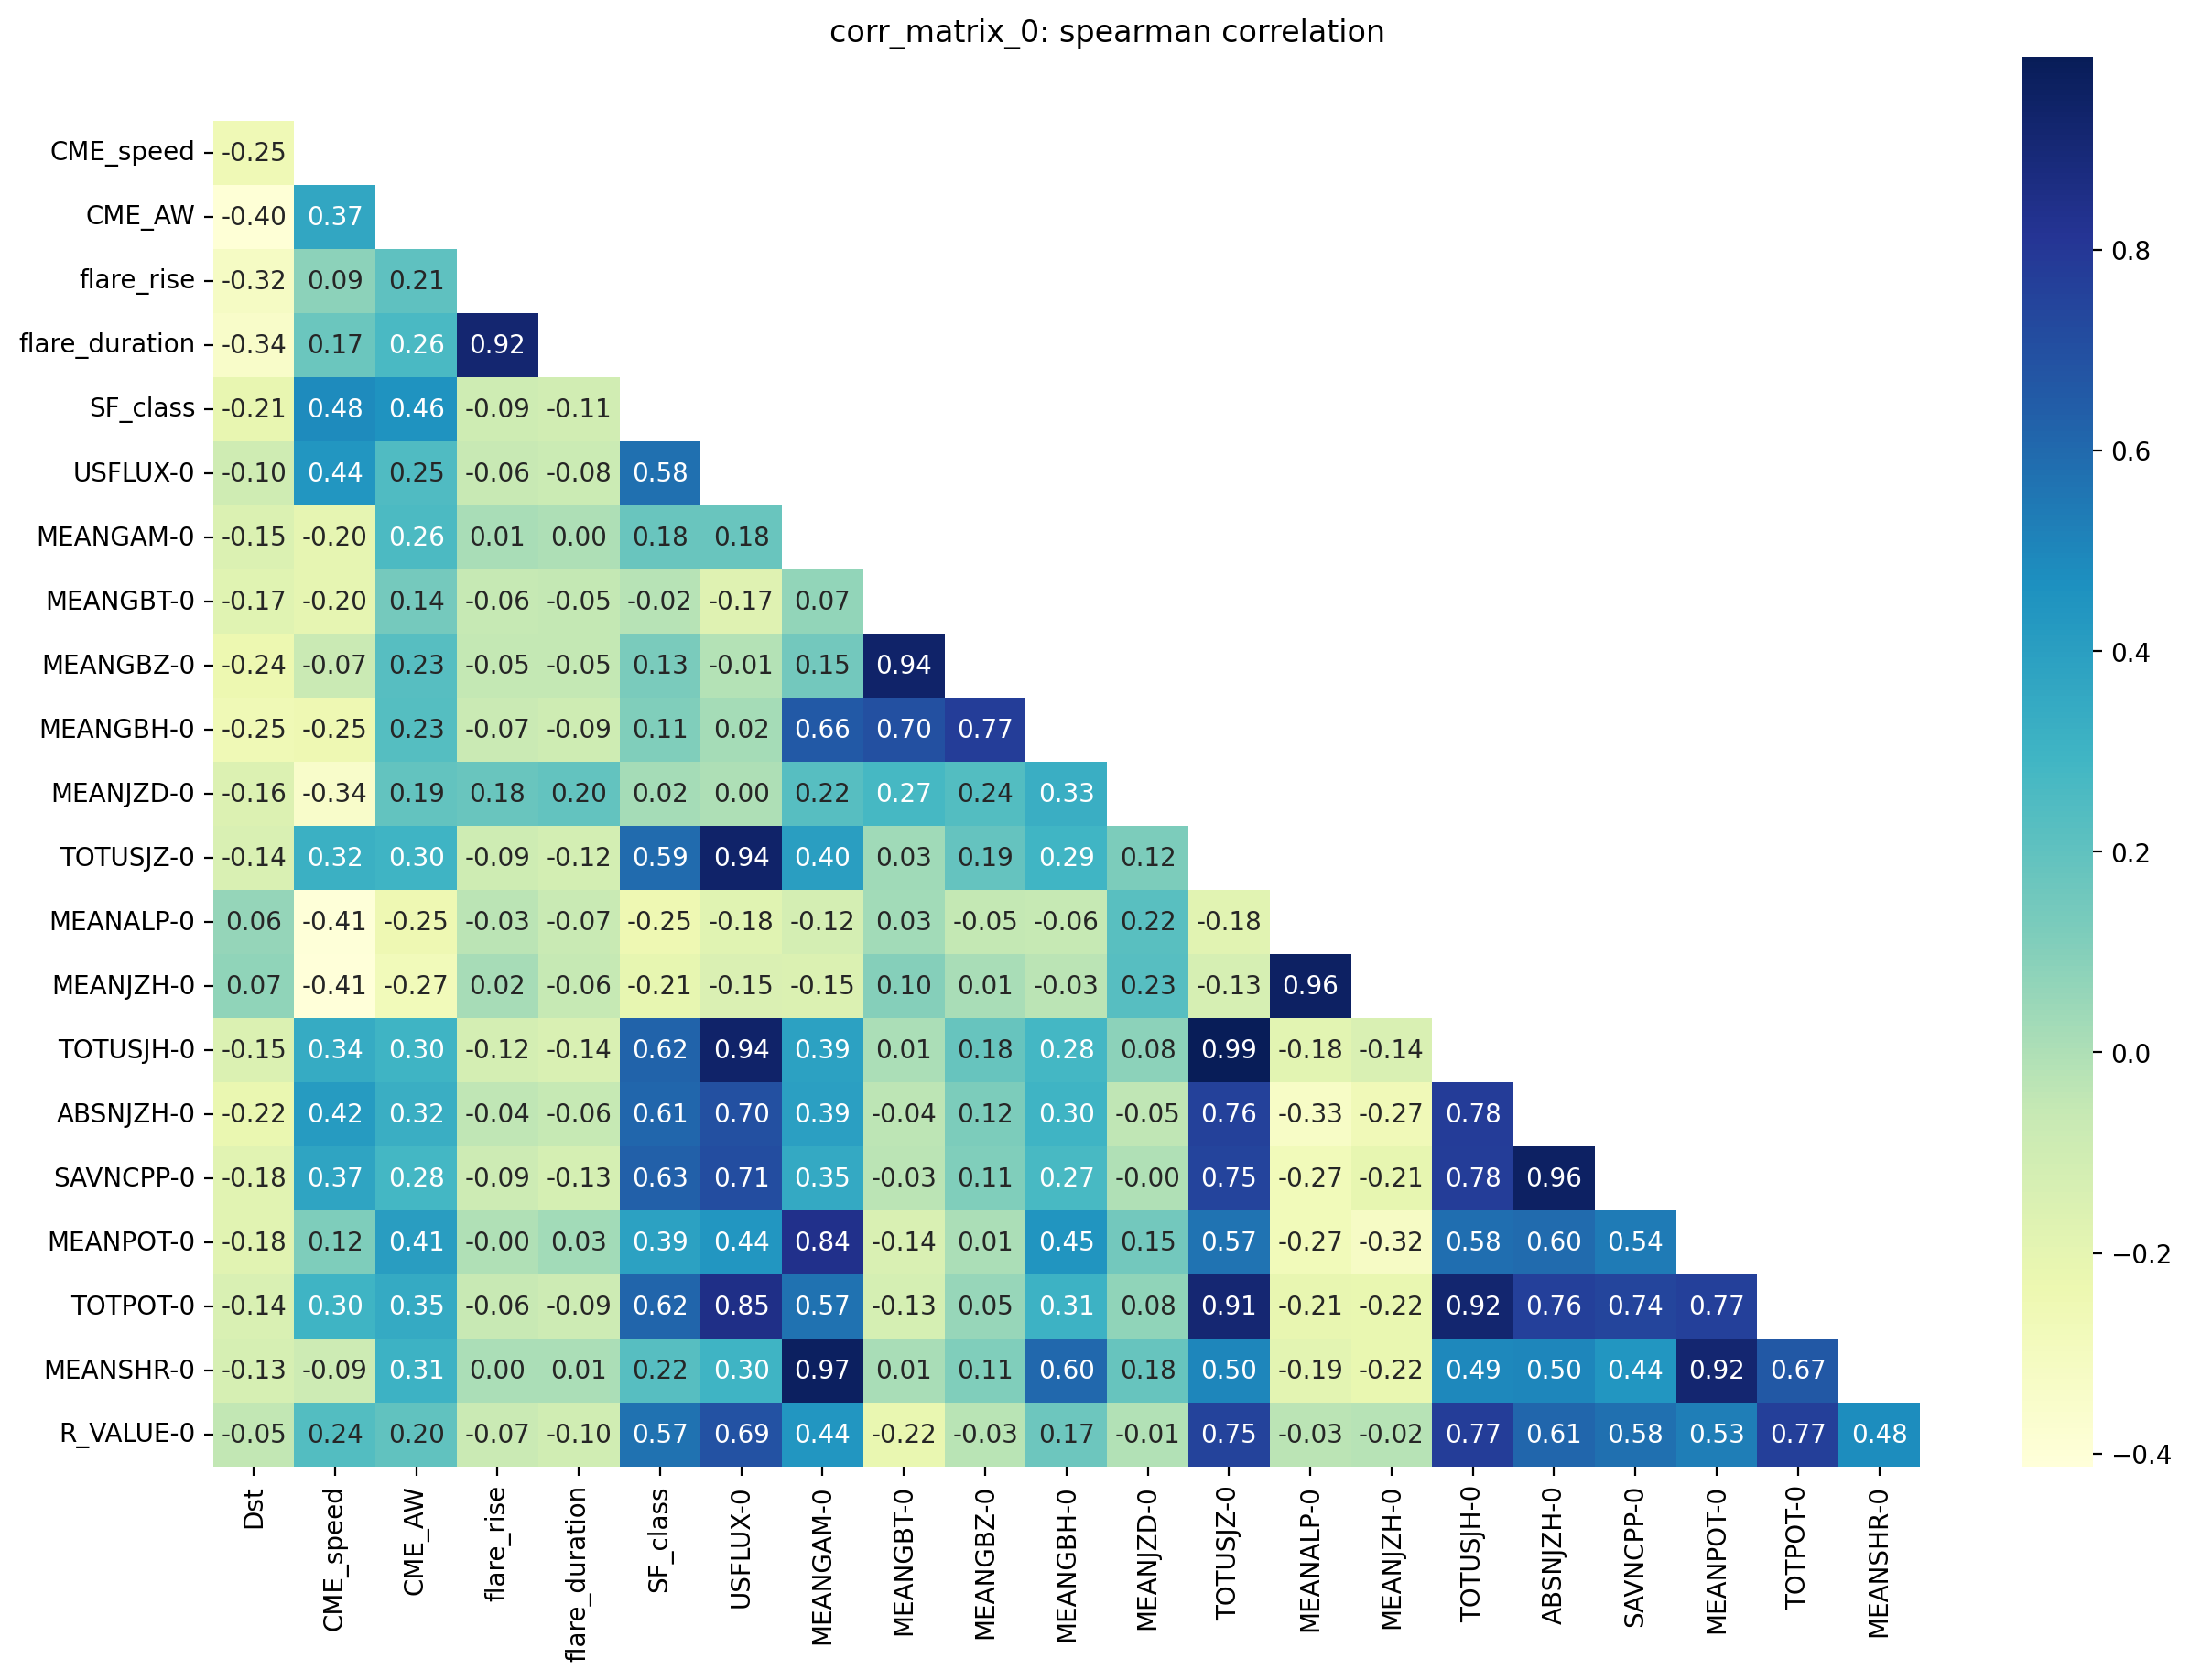

In [90]:
corr_method = 'spearman'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Create a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
df.columns

Index(['Dst', 'CME_speed', 'CME_AW', 'flare_rise', 'flare_duration',
       'SF_class', 'USFLUX-0', 'MEANGAM-0', 'MEANGBT-0', 'MEANGBZ-0',
       'MEANGBH-0', 'MEANJZD-0', 'TOTUSJZ-0', 'MEANALP-0', 'MEANJZH-0',
       'TOTUSJH-0', 'ABSNJZH-0', 'SAVNCPP-0', 'MEANPOT-0', 'TOTPOT-0',
       'MEANSHR-0', 'R_VALUE-0'],
      dtype='object')

In [92]:
df.columns[6:-1]

Index(['USFLUX-0', 'MEANGAM-0', 'MEANGBT-0', 'MEANGBZ-0', 'MEANGBH-0',
       'MEANJZD-0', 'TOTUSJZ-0', 'MEANALP-0', 'MEANJZH-0', 'TOTUSJH-0',
       'ABSNJZH-0', 'SAVNCPP-0', 'MEANPOT-0', 'TOTPOT-0', 'MEANSHR-0'],
      dtype='object')

In [93]:
keys = df.columns[6:-1]

In [95]:
keys

Index(['USFLUX-0', 'MEANGAM-0', 'MEANGBT-0', 'MEANGBZ-0', 'MEANGBH-0',
       'MEANJZD-0', 'TOTUSJZ-0', 'MEANALP-0', 'MEANJZH-0', 'TOTUSJH-0',
       'ABSNJZH-0', 'SAVNCPP-0', 'MEANPOT-0', 'TOTPOT-0', 'MEANSHR-0'],
      dtype='object')

In [97]:
df.dropna(axis=0, inplace=True)
df

Dst  CME_speed  CME_AW  flare_rise  flare_duration  SF_class   
0   -74.0        850   360.0        31.0           100.0      3.20  \
1   -83.0       2125   360.0        29.0            75.0     37.00   
2  -115.0       1315   360.0        16.0            23.0     93.00   
3   -75.0        575   360.0         8.0            12.0    210.00   
4  -118.0       1915   360.0        47.0            97.0     71.00   
5   -68.0        972   360.0        12.0            32.0     30.00   
6  -147.0       1005   360.0        70.0           189.0     13.00   
7   -71.0       1120   360.0       141.0           246.0     32.00   
8   -75.0       2175   360.0        21.0            56.0     87.00   
9   -57.0       1039    97.0        40.0            55.0      0.59   
10  -50.0        710   206.0        17.0            38.0     33.00   
11  -88.0       1306   360.0        23.0           107.0     20.00   
12 -145.0       2684   360.0        22.0            38.0    540.00   
13  -64.0       1296   360.0        29.0            75.0     84.00   
14  -88.0       1884   360.0        29.0            73.0     79.00   
15  -60.0        921   360.0        32.0            56.0      3.90   
16  -86.0        987   360.0       103.0           184.0     19.00   
17  -78.0       1828   360.0         7.0            13.0    110.00   
18 -139.0        885   360.0        72.0           113.0    140.00   
19  -69.0       1442   360.0        58.0           126.0      8.40   
20  -64.0        538   360.0         8.0            20.0      2.90   
21 -122.0        947   360.0        21.0            58.0      3.70   
22  -90.0        692   122.0        70.0           125.0      2.00   
23  -55.0        622   138.0         7.0            14.0      0.83   
24 -132.0       1063   360.0        72.0           169.0    110.00   
25  -59.0        663   177.0         7.0            12.0      0.68   
26  -61.0       1366   360.0        23.0            33.0    120.00   
27  -51.0       1345   360.0        14.0            36.0     32.00   
28  -59.0       1466   360.0        24.0            60.0     50.00   
29  -87.0        807   267.0         8.0            18.0     15.00   
30  -72.0       1179   360.0       116.0           200.0      1.20   
31  -54.0        695   360.0        22.0            31.0    100.00   
32 -119.0        634   360.0         6.0             9.0     11.00   
33  -97.0       2147   360.0        10.0            24.0    490.00   
34  -65.0        795   293.0        33.0            41.0    160.00   
35  -71.0        587   360.0        26.0            55.0     87.00   
36  -57.0       1195   360.0        17.0             4.0     69.00   
37  -53.0        830   257.0        17.0            44.0    180.00   
38  -57.0        669   360.0        53.0            93.0     10.00   
39 -234.0        719   360.0        58.0           125.0      9.10   
40 -198.0       1366   360.0        40.0            58.0     20.00   
41  -81.0       1209   360.0        44.0            72.0     65.00   
42  -51.0       1627   360.0        14.0            63.0     79.00   
43  -98.0        647   204.0        60.0           141.0      0.70   
44  -57.0        547   360.0        10.0            20.0     12.00   
45  -81.0        823   131.0       129.0           178.0      2.60   
46  -56.0        770    79.0         6.0            10.0      0.64   
47  -51.0        751   114.0         3.0             7.0      1.30   
48  -87.0        578   360.0        21.0            42.0     37.00   
49  -56.0       1041   273.0        23.0            39.0     39.00   
50  -55.0        628    84.0        25.0            53.0      1.40   
51 -166.0        579   360.0        29.0            49.0      6.60   
52  -53.0        684    71.0         9.0            14.0      3.30   
53  -65.0        719   360.0        45.0            70.0      8.90   
54  -51.0        926   360.0        49.0            88.0      5.50   
55  -72.0       1200   360.0        62.0           137.0     24.00   
56 -122.0       

keys vs. Dst

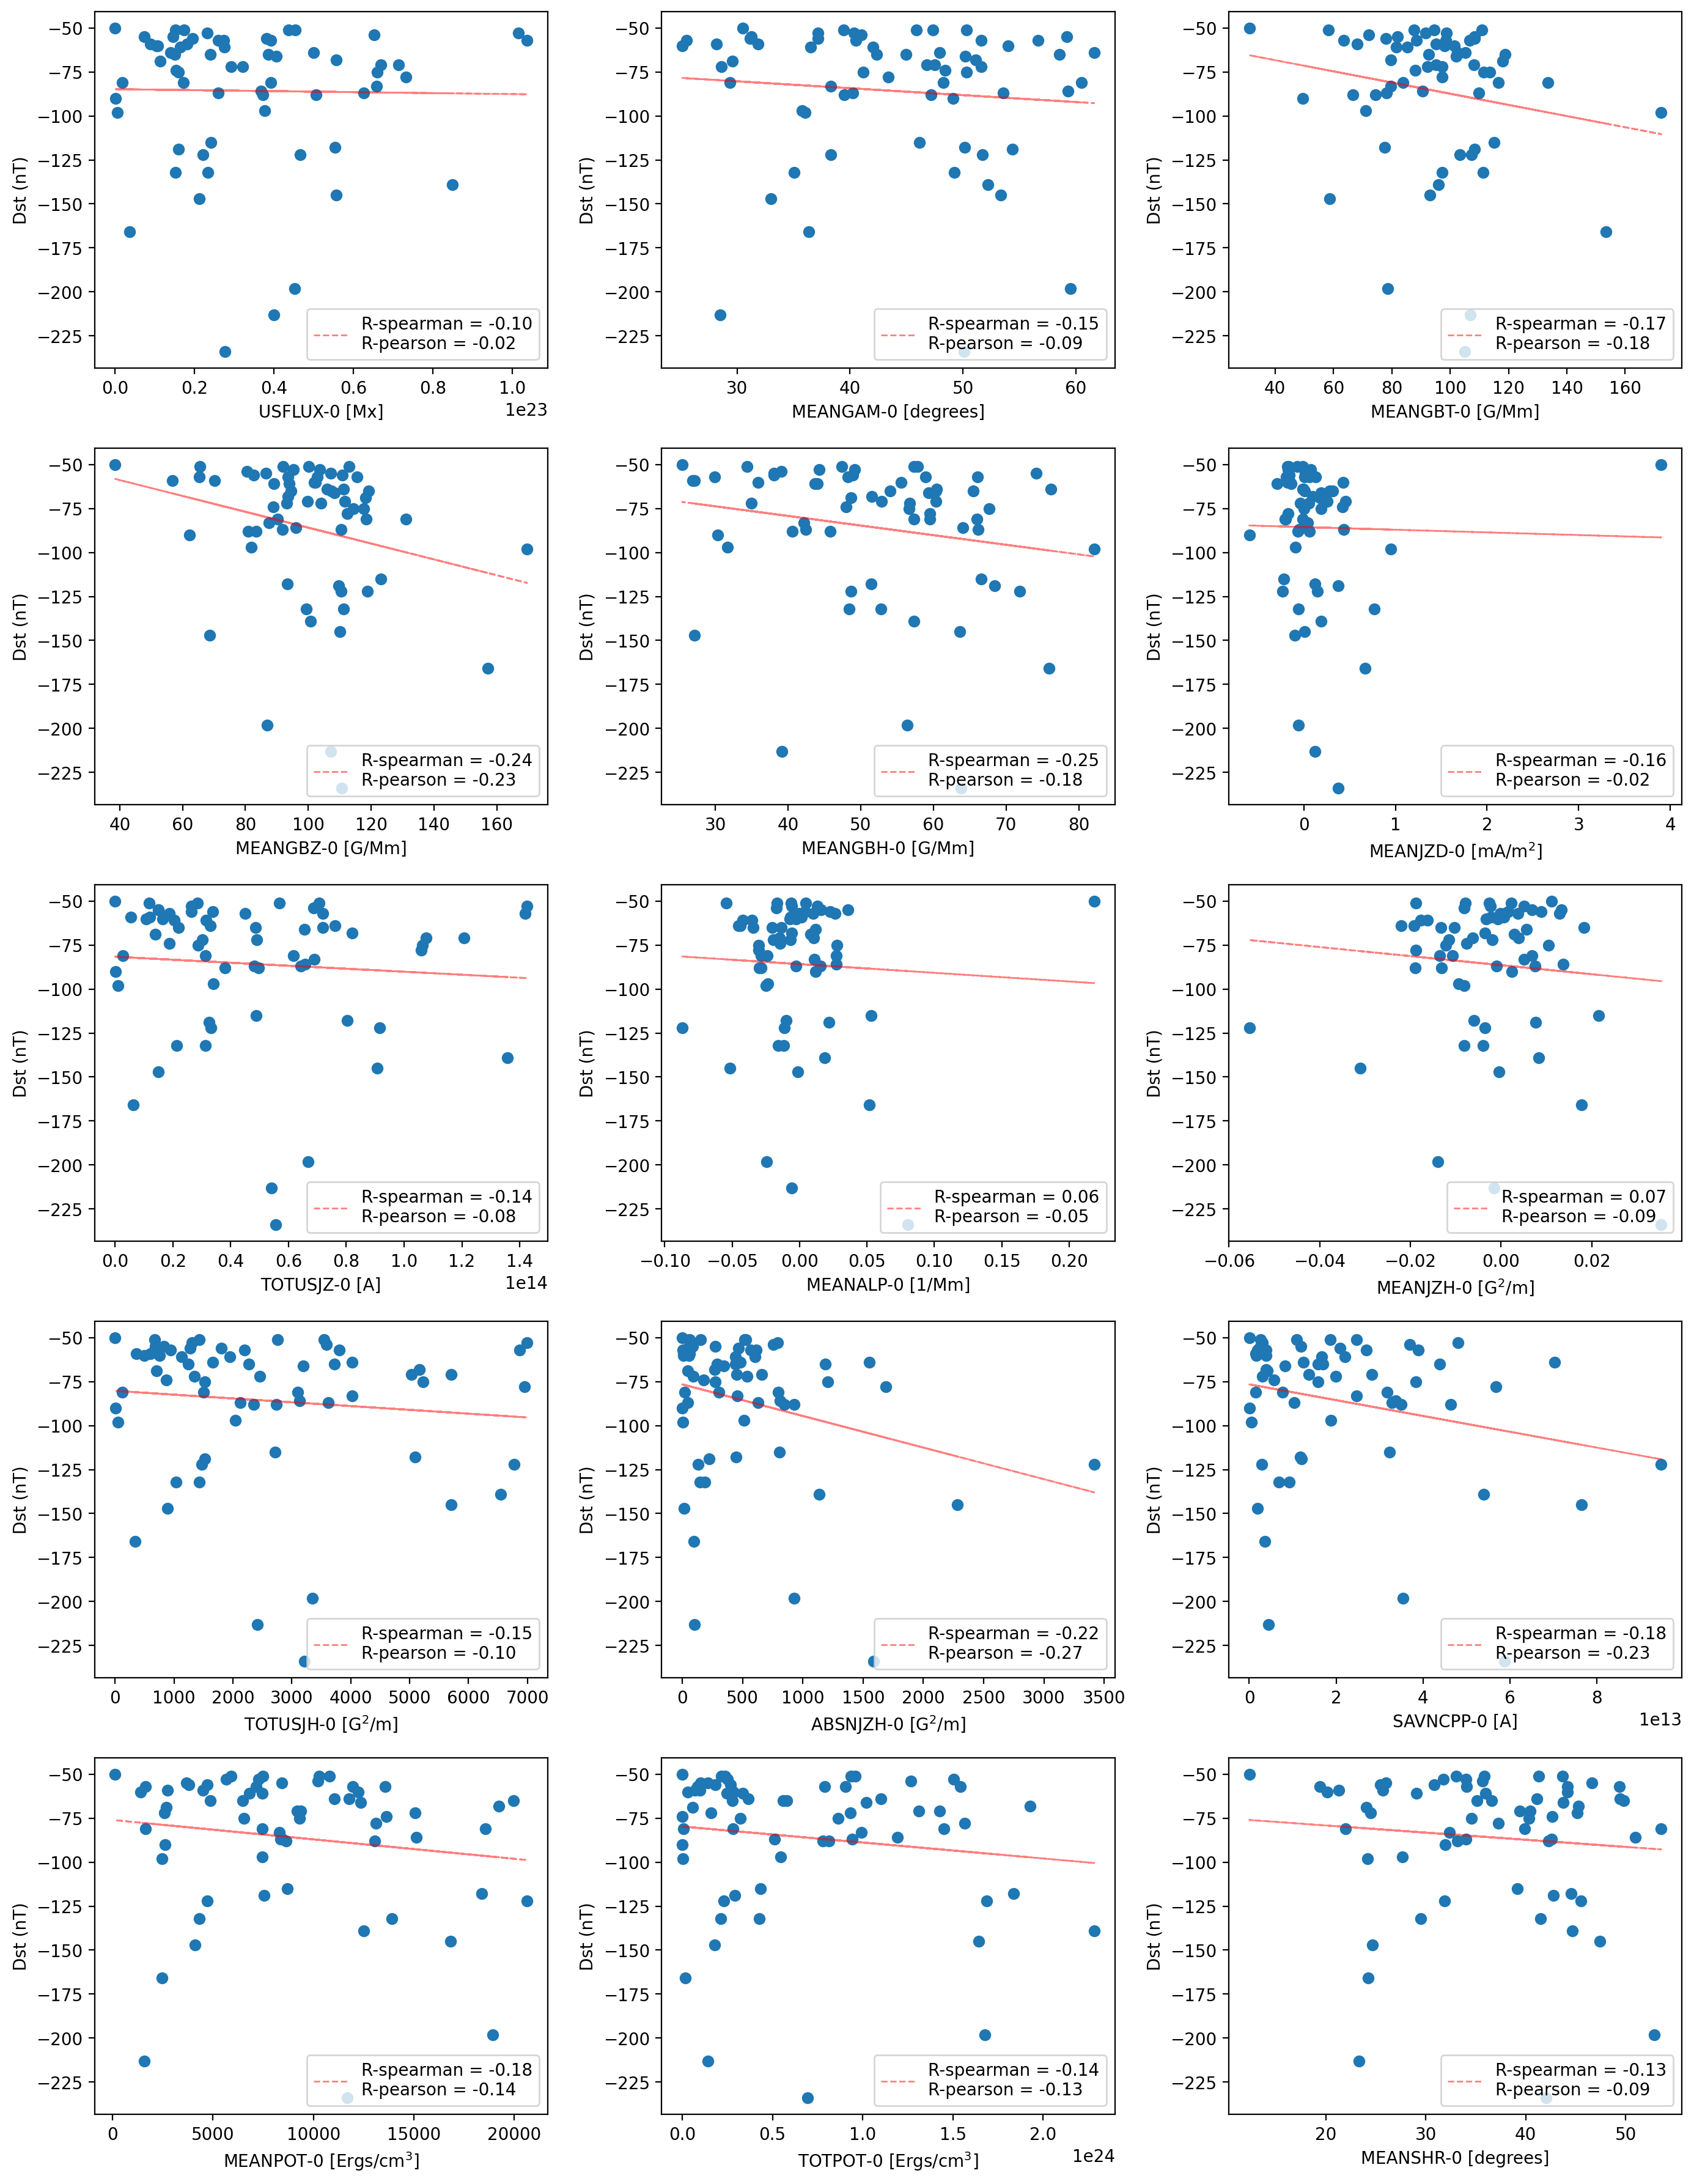

In [98]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['Dst'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['Dst'])
    pearsonr_corr, _ = pearsonr(df[key], df['Dst'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['Dst'])
    ax.set_ylabel('Dst (nT)')
    ax.legend(loc='lower right')

    if key == f'USFLUX-{param_type}':
        ax.set_xlabel(f'{key} [Mx]')
    elif key == f'MEANGAM-{param_type}' or key == f'MEANSHR-{param_type}':
        ax.set_xlabel(f'{key} [degrees]')
    elif key == f'MEANGBZ-{param_type}' or key == f'MEANGBH-{param_type}' or key == f'MEANGBT-{param_type}':
        ax.set_xlabel(f'{key} [G/Mm]')
    elif key == f'MEANJZD-{param_type}':
        ax.set_xlabel(f'{key} [mA/m$^2$]')
    elif key == f'TOTUSJZ-{param_type}' or key == f'SAVNCPP-{param_type}':
        ax.set_xlabel(f'{key} [A]')
    elif key == f'MEANALP-{param_type}':
        ax.set_xlabel(f'{key} [1/Mm]')
    elif key == f'MEANJZH-{param_type}' or key == f'TOTUSJH-{param_type}' or key == f'ABSNJZH-{param_type}':
        ax.set_xlabel(f'{key} [G$^2$/m]')
    elif key == f'MEANPOT-{param_type}' or key == f'TOTPOT-{param_type}':
        ax.set_xlabel(f'{key} [Ergs/cm$^3$]')

fig.tight_layout()
fig.savefig(f'./{filename}_scatterplots_Dst.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

keys vs. CME speed

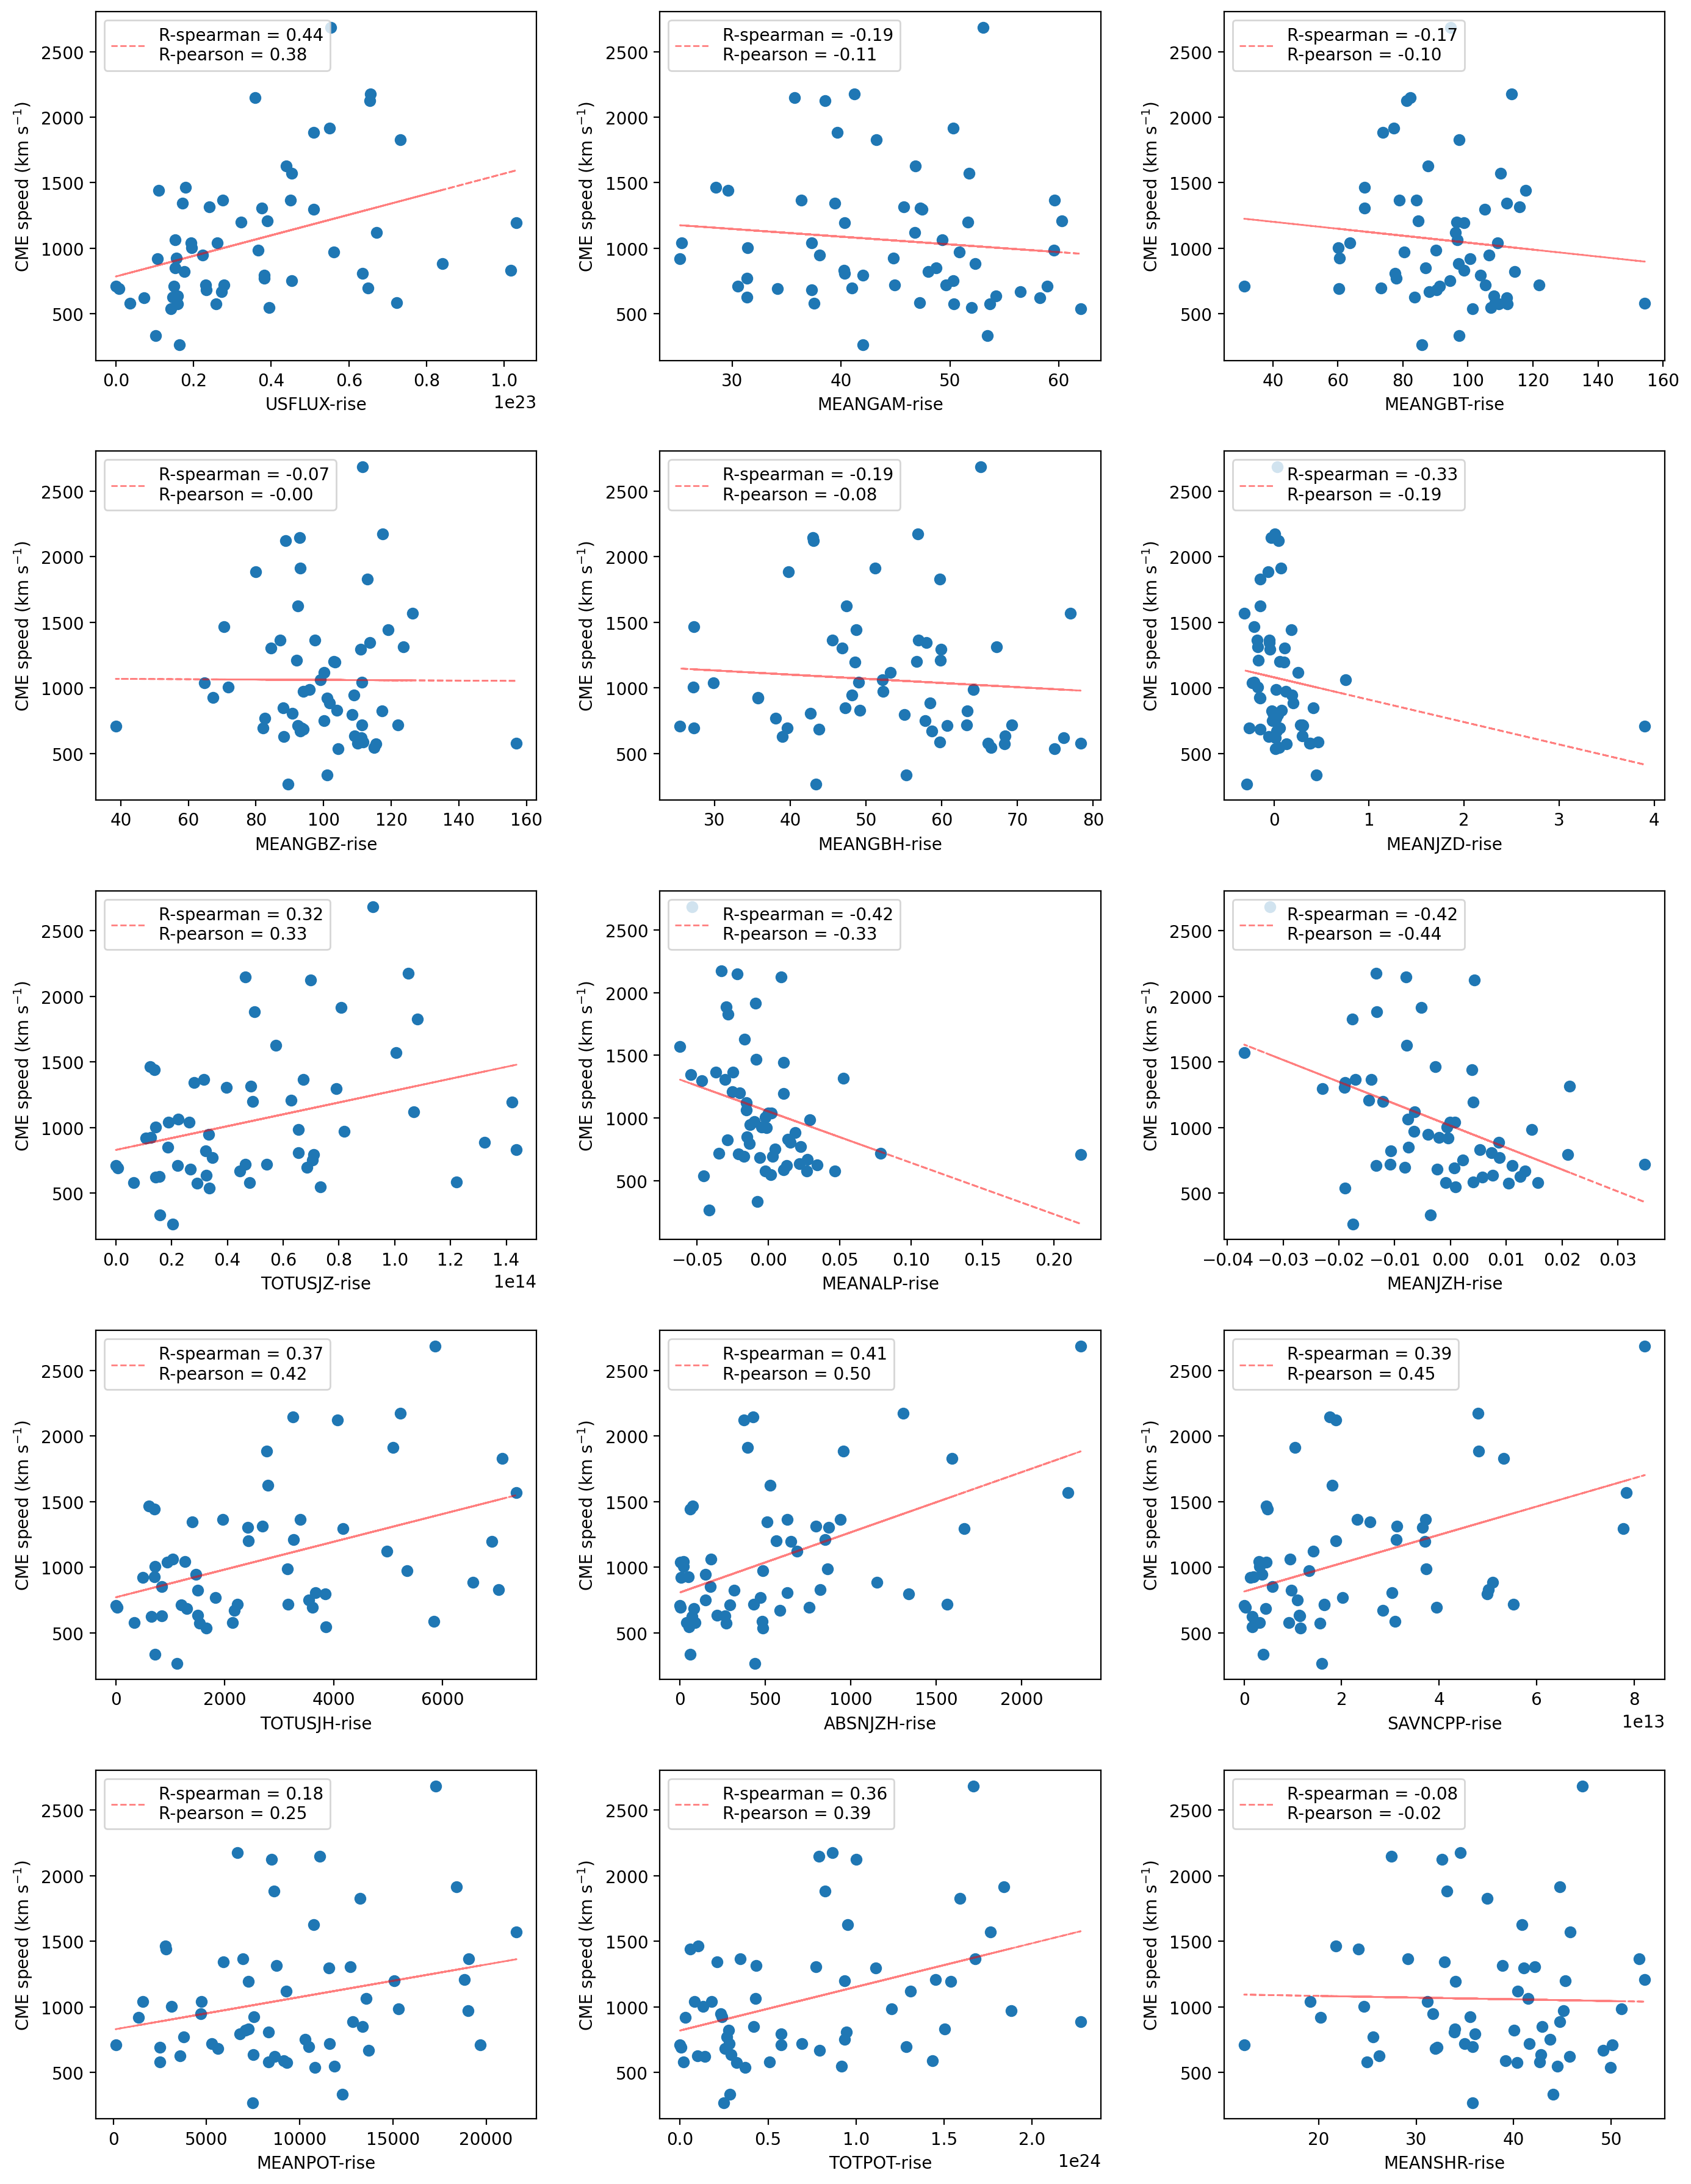

In [44]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['CME_speed'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['CME_speed'])
    pearsonr_corr, _ = pearsonr(df[key], df['CME_speed'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['CME_speed'])
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('CME speed (km s$^{-1}$)')
    ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_CMEspeed.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

keys vs. flare rise time

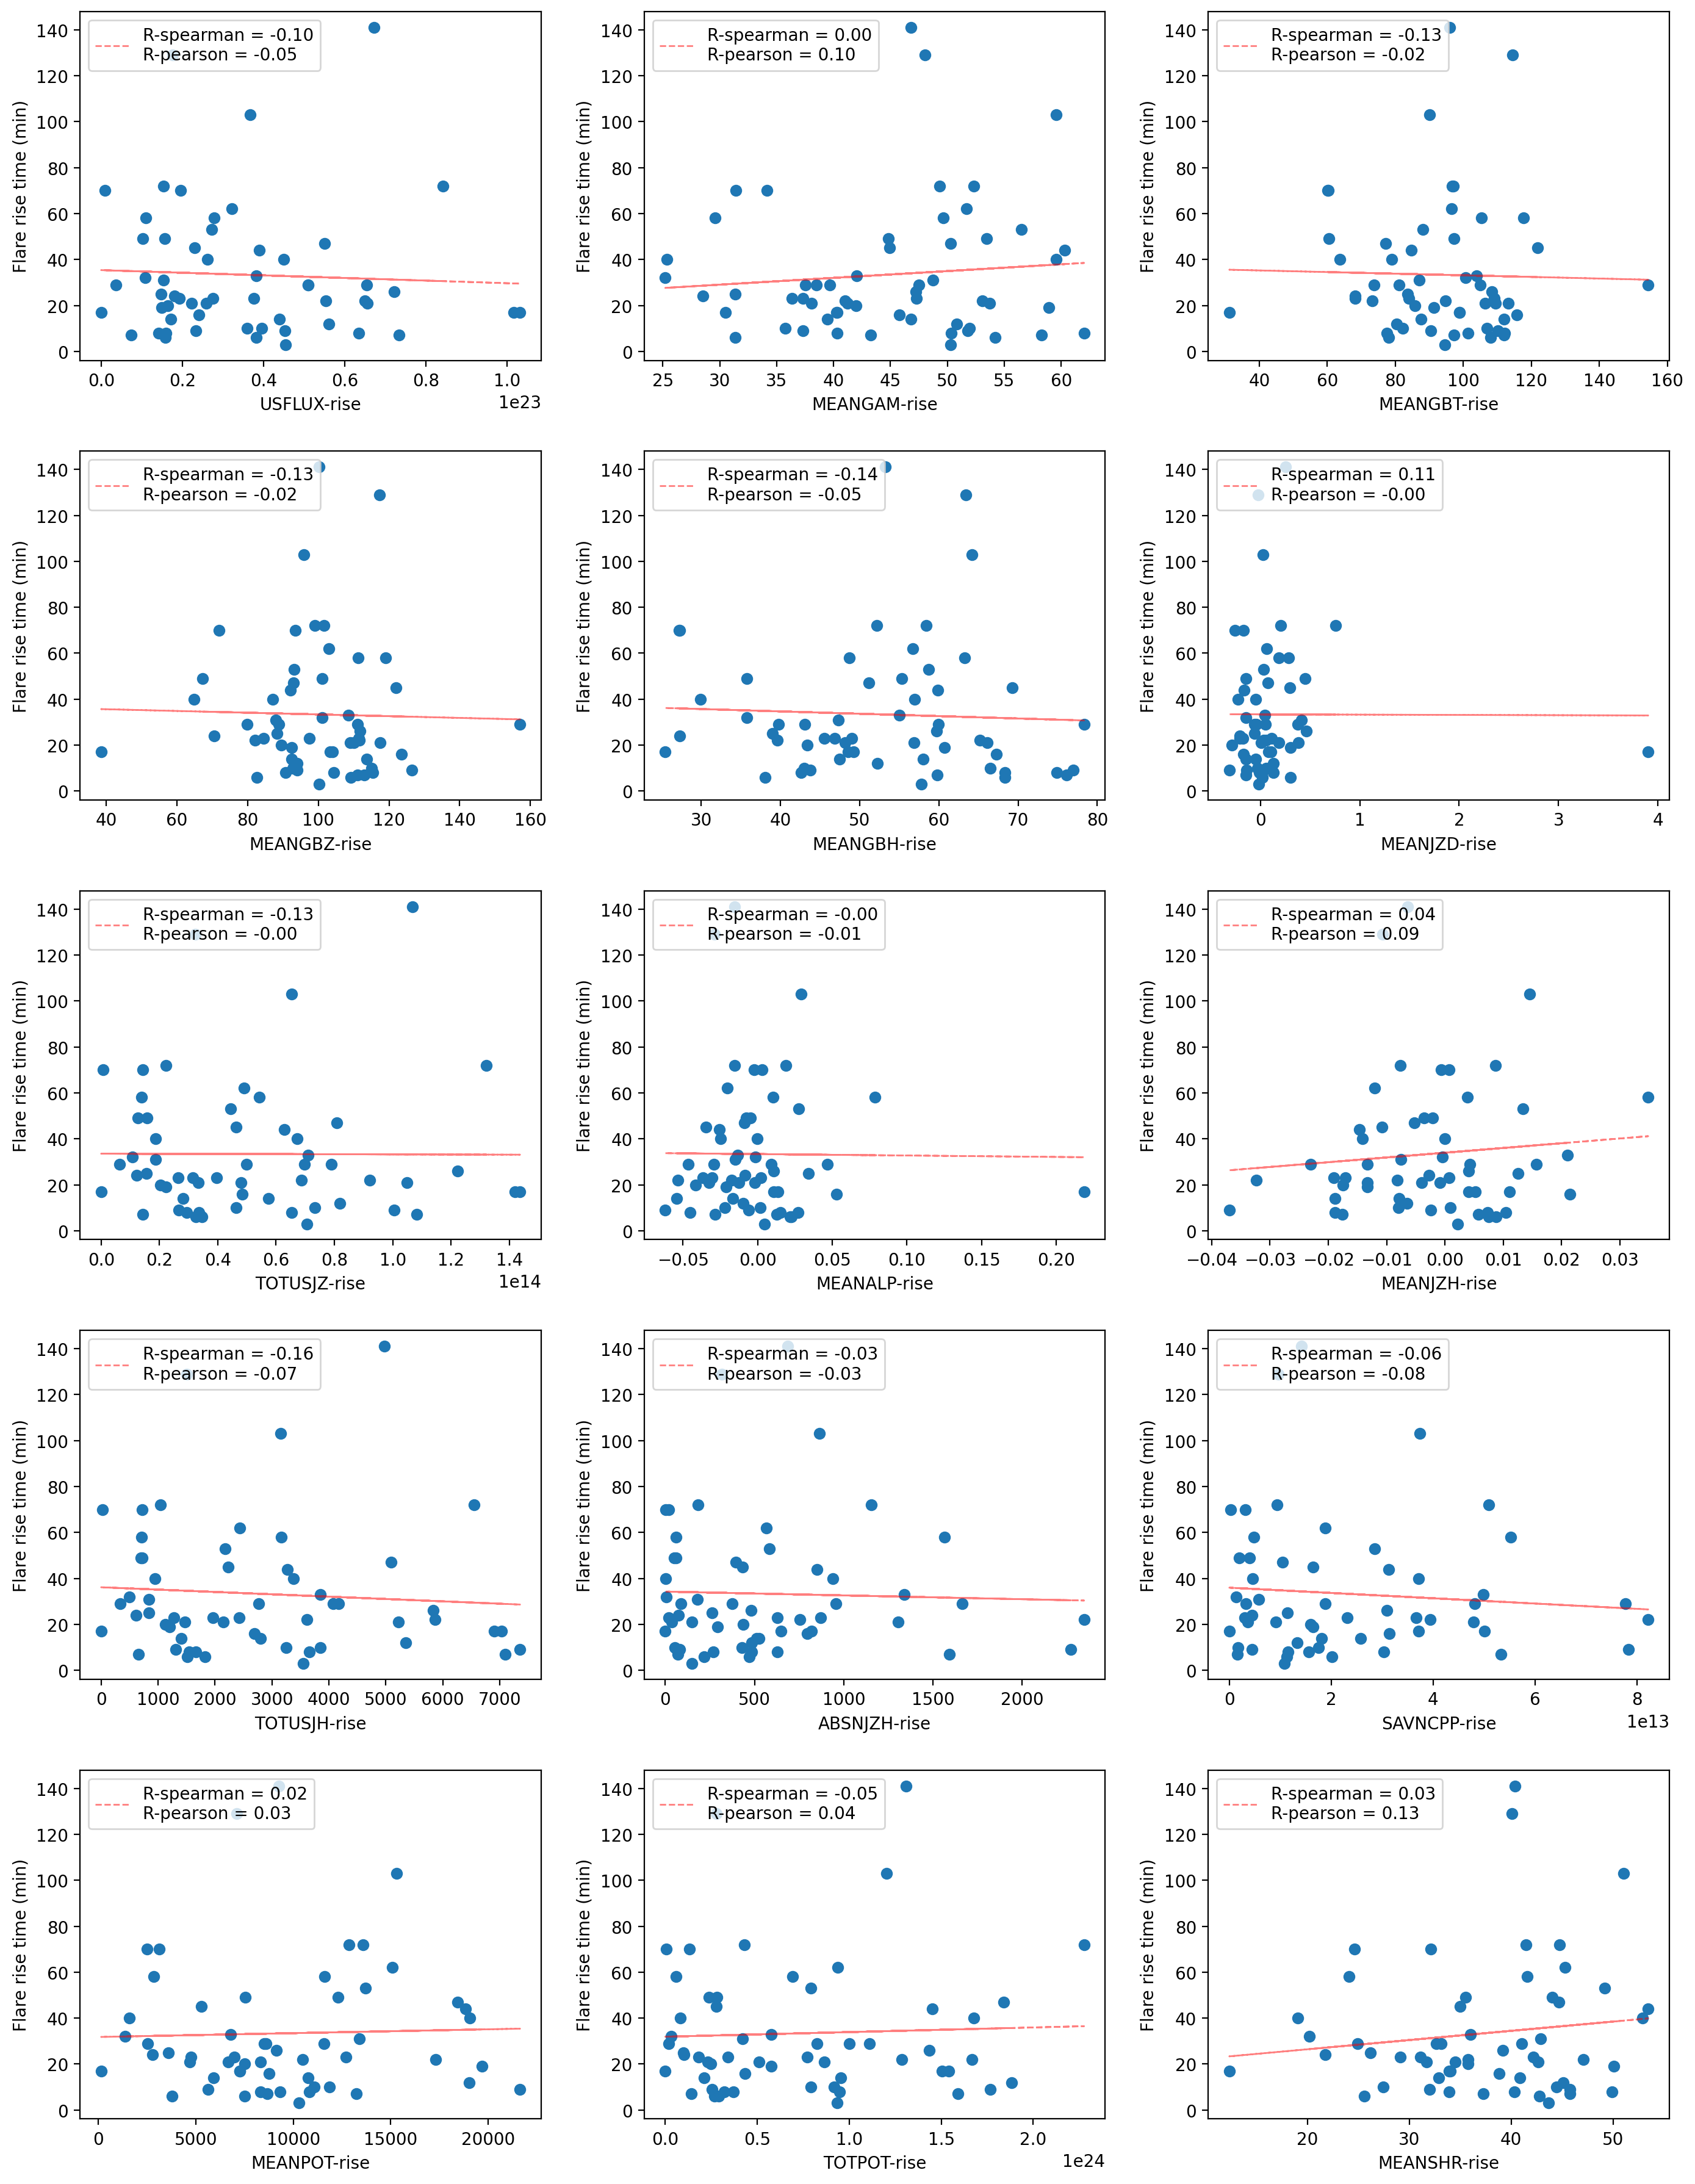

In [45]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['flare_rise'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['flare_rise'])
    pearsonr_corr, _ = pearsonr(df[key], df['flare_rise'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['flare_rise'])
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('Flare rise time (min)')
    ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_flareRise.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

keys vs. flare duration

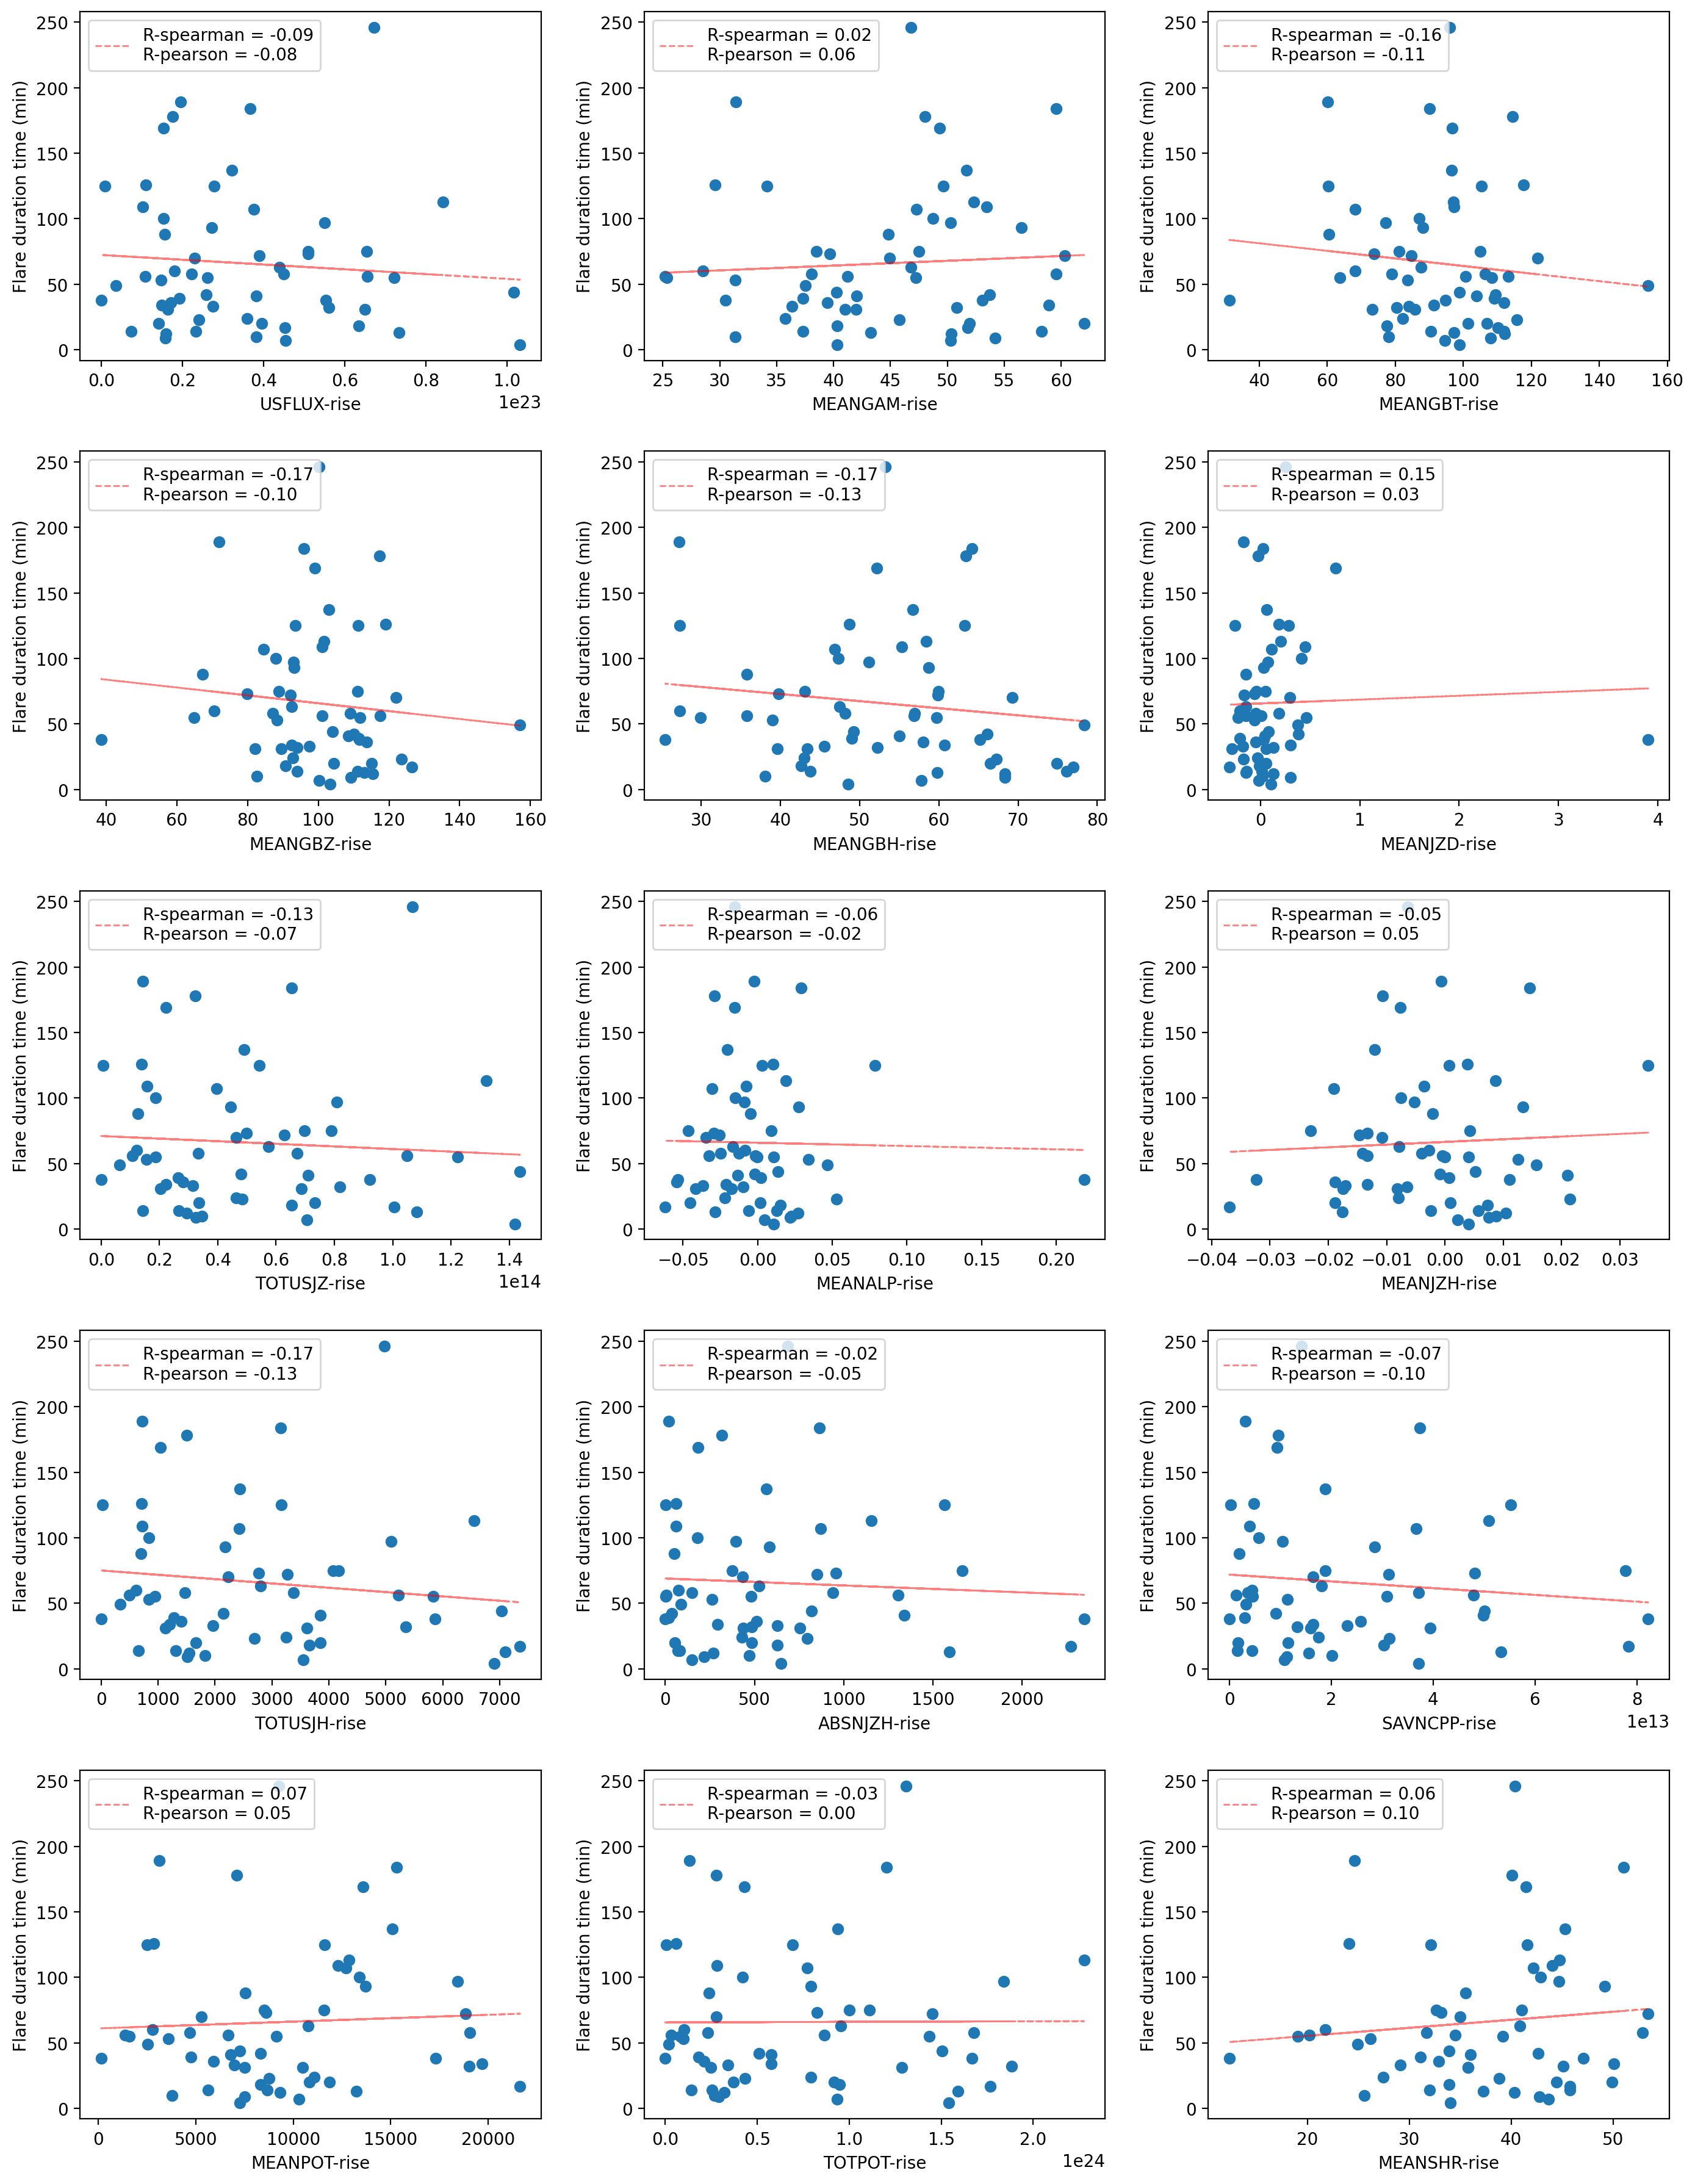

In [46]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['flare_duration'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['flare_duration'])
    pearsonr_corr, _ = pearsonr(df[key], df['flare_duration'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['flare_duration'])
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('Flare duration time (min)')
    ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_flareDuration.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

keys vs. solar flare class

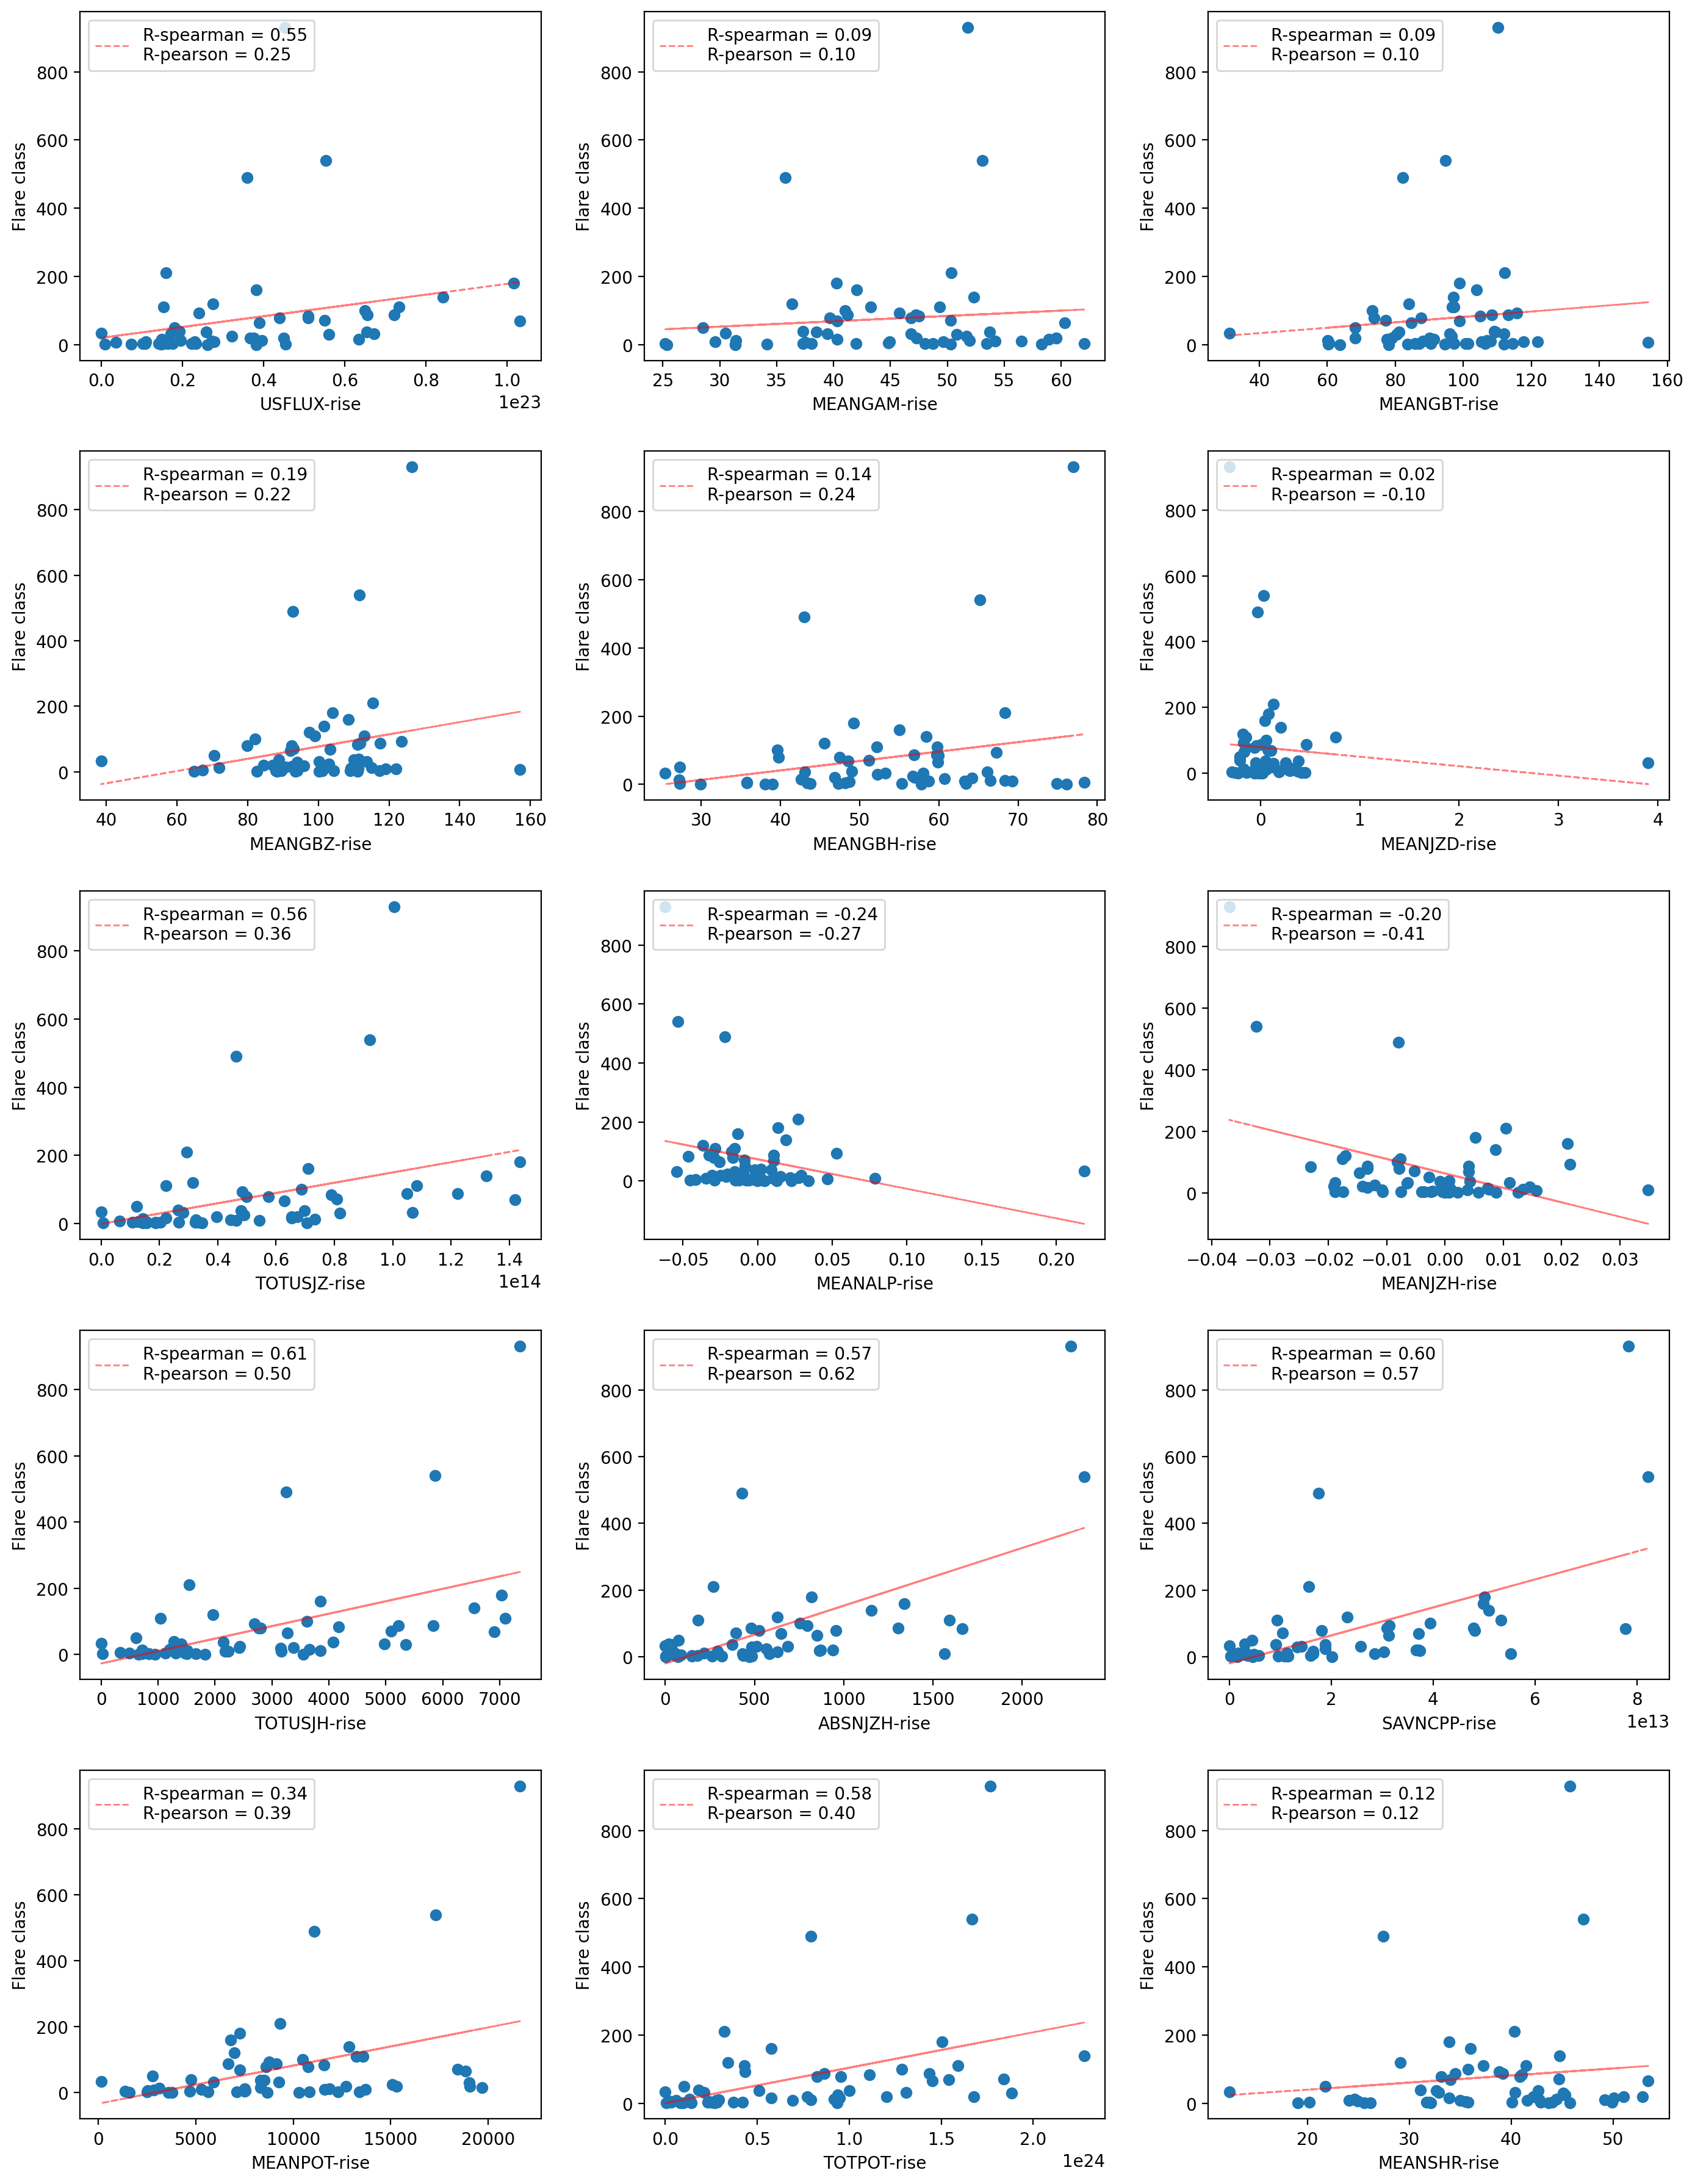

In [47]:
fig = plt.figure(figsize=[14,18])

for i, key in enumerate(keys):
    ax = fig.add_subplot(5,3,i+1)

    # Calculate linear fit
    m, b = np.polyfit(df[key], df['SF_class'], 1)

    # Calculate correlation coefficients
    spearman_corr, _ = spearmanr(df[key], df['SF_class'])
    pearsonr_corr, _ = pearsonr(df[key], df['SF_class'])
    ax.plot(df[key], m*df[key] + b, c='red', ls='--', lw='1', alpha=0.5, label=f'R-spearman = {spearman_corr:.2f}\nR-pearson = {pearsonr_corr:.2f}')

    ax.scatter(df[key], df['SF_class'])
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('Flare class')
    ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'./{filename}_scatterplots_flareClass.png', format='png', dpi=300, bbox_inches='tight')
plt.show()